## Encoder-Only PatchSeq Analysis ##

This notebook implements an encoder-only version of UnitedNet for PatchSeq data,
focusing purely on unsupervised group identification without reconstruction losses.

In [1]:
# Standard imports
import anndata as ad
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from scipy.optimize import linear_sum_assignment
import copy
import torch
import os
import sys

In [2]:
# Add parent directory to path
sys.path.append('..')

In [3]:
# Custom imports
from src.encoder_only.encoder_only_model import EncoderOnlyUnitedNet
from src.configs.encoder_only_patchseq import encoder_only_patchseq_config
from src.data import patch_seq_pre_ps, partitions
from src.constants import *

## Configurations ##

In [4]:
# Set this to split training : testing data size
K_FOLDS = 3

In [5]:
# Paths and device configuration
TECHNIQUE = 'patchseq_encoder_only'
DATA_PATH = "../data/patchseq"
DEVICE = "mps"
ROOT_SAVE_PATH = f"../saved_results/{TECHNIQUE}"


In [6]:
# Create results directory
os.makedirs(ROOT_SAVE_PATH, exist_ok=True)
os.makedirs('./figures/', exist_ok=True)


In [7]:
print(f"Configuration:")
print(f"- Technique: {TECHNIQUE}")
print(f"- Device: {DEVICE}")
print(f"- K-folds: {K_FOLDS}")
print(f"- Data path: {DATA_PATH}")
print(f"- Save path: {ROOT_SAVE_PATH}")

Configuration:
- Technique: patchseq_encoder_only
- Device: mps
- K-folds: 3
- Data path: ../data/patchseq
- Save path: ../saved_results/patchseq_encoder_only


## Load Data ##

In [8]:
# Load the three modalities
adata_rna_raw = sc.read_h5ad(f'{DATA_PATH}/adata_RNA_TEM.h5ad')
adata_ephys_raw = sc.read_h5ad(f'{DATA_PATH}/adata_Ephys_TEM.h5ad')
adata_morph_raw = sc.read_h5ad(f'{DATA_PATH}/adata_Morph_TEM.h5ad')


In [9]:
print(f"Loaded data shapes:")
print(f"- RNA: {adata_rna_raw.shape}")
print(f"- Ephys: {adata_ephys_raw.shape}")
print(f"- Morph: {adata_morph_raw.shape}")


Loaded data shapes:
- RNA: (448, 1252)
- Ephys: (448, 68)
- Morph: (448, 514)


In [10]:
# Create cross-validation splits
ind_dict = partitions(adata_rna_raw.obs['cell_type_TEM'], n_partitions=K_FOLDS, seed=0)
print(f"Created {K_FOLDS}-fold cross-validation splits")

Created 3-fold cross-validation splits


In [11]:
# Display cell type distribution
ct_df = pd.DataFrame({'ct': adata_rna_raw.obs['cell_type_TEM'].values})
print("\nCell type distribution:")
print(ct_df.ct.value_counts().sort_values(ascending=False))



Cell type distribution:
ct
Sst-MET-12     54
Lamp5-MET-1    41
Pvalb-MET-4    38
Pvalb-MET-2    30
Sst-MET-3      24
Sst-MET-13     23
Vip-MET-1      21
Vip-MET-5      20
Sst-MET-2      17
Sncg-MET-1     17
Sst-MET-6      17
Sst-MET-8      17
Vip-MET-4      16
Sst-MET-1      15
Sst-MET-4      14
Sst-MET-9      13
Vip-MET-2      12
Sst-MET-5      12
Sst-MET-10     10
Pvalb-MET-3     9
Sst-MET-7       9
Pvalb-MET-1     5
Sst-MET-11      3
Pvalb-MET-5     3
Vip-MET-3       3
Sncg-MET-2      3
Lamp5-MET-2     2
Name: count, dtype: int64


## Cross Validation ##

In [12]:
def run_single_fold(cv_fold):
    """Run encoder-only training for a single cross-validation fold"""
    
    print(f"\n{'='*60}")
    print(f"CROSS-VALIDATION FOLD {cv_fold + 1}/{K_FOLDS}")
    print(f"{'='*60}")
    
    # Prepare data splits
    print("Preparing data splits...")
    adatas_train, adatas_test, _ = patch_seq_pre_ps(
        adata_rna_raw, adata_ephys_raw, adata_morph_raw, 
        cv_fold, ind_dict, split=True
    )
    
    print(f"Training set sizes: {[adata.shape for adata in adatas_train]}")
    print(f"Test set sizes: {[adata.shape for adata in adatas_test]}")
    
    # Set up model save path
    fold_save_path = f"{ROOT_SAVE_PATH}/fold_{cv_fold}"
    
    # Initialize encoder-only model
    print("Initializing encoder-only UnitedNet model...")
    model = EncoderOnlyUnitedNet(
        fold_save_path, 
        device=DEVICE, 
        technique=encoder_only_patchseq_config
    )
    
    # Stage 1: Initial training on labeled data
    print("\n--- Stage 1: Initial supervised training ---")
    model.train(adatas_train, adatas_val=adatas_test, verbose=True)
    
    # Evaluate initial performance
    print("\n--- Evaluating initial model ---")
    initial_metrics = model.evaluate(adatas_test)
    print("Initial test metrics:")
    for key, value in initial_metrics.items():
        if isinstance(value, np.ndarray):
            if value.size > 6:
                print(f"  {key}: Array shape {value.shape}")
            else:
                print(f"  {key}: {value}")
        else:
            print(f"  {key}: {value:.4f}")
    
    # Stage 2: Unsupervised clustering on all data
    print("\n--- Stage 2: Unsupervised clustering on all data ---")
    
    # Prepare full dataset (no train/test split for clustering)
    _, _, adatas_all = patch_seq_pre_ps(
        adata_rna_raw, adata_ephys_raw, adata_morph_raw, 
        cv_fold, ind_dict, split=False
    )
    
    # Load best supervised model
    print("Loading best supervised model...")
    model.load_model(f"{fold_save_path}/train_best.pt", device=DEVICE)
    model.model.device_in_use = DEVICE
    
    # Configure for unsupervised clustering
    model.model.config[str_train_task] = str_unsupervised_group_identification
    
    # Reset and retrain classification layers
    print("Retraining for unsupervised clustering...")
    model.train(adatas_all, verbose=True, init_classify=True)
    
    return model, adatas_all, initial_metrics


In [13]:
# Run CV
print(f"\n{'='*60}")
print("STARTING CROSS-VALIDATION EXPERIMENTS")
print(f"{'='*60}")

all_results = []

for cv in range(K_FOLDS):
    # Run single fold
    model, adatas_all, initial_metrics = run_single_fold(cv)
    # Store the results for this fold
    fold_result = {
        'fold': cv,
        'model': model,
        'adatas_all': adatas_all,
        'initial_metrics': initial_metrics,
        'success': True
    }
    
    all_results.append(fold_result)
    print(f"Fold {cv} completed and stored in results")
    



STARTING CROSS-VALIDATION EXPERIMENTS

CROSS-VALIDATION FOLD 1/3
Preparing data splits...
Training set sizes: [(298, 1252), (298, 68), (298, 514)]
Test set sizes: [(150, 1252), (150, 68), (150, 514)]
Initializing encoder-only UnitedNet model...

--- Stage 1: Initial supervised training ---
Training encoder-only model for unsupervised clustering


  1%|▏         | 1/80 [00:03<04:55,  3.73s/it]



Best model saved with loss: 1.4831651449203491
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.28
ari: 0.08426601854577624
nmi: 0.5100067165612584


  2%|▎         | 2/80 [00:06<04:09,  3.20s/it]



Best model saved with loss: 1.4120450019836426
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.36
ari: 0.14888536956889672
nmi: 0.5716127039810099


  4%|▍         | 3/80 [00:09<03:52,  3.02s/it]



Best model saved with loss: 1.294881820678711
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.37333333333333335
ari: 0.1700037639271592
nmi: 0.5930846603759427


  5%|▌         | 4/80 [00:12<03:43,  2.94s/it]



Best model saved with loss: 1.2777650356292725
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.41333333333333333
ari: 0.19174911230478628
nmi: 0.6059308123357645


  6%|▋         | 5/80 [00:14<03:36,  2.88s/it]



Best model saved with loss: 1.236592411994934
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 

Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_5.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4266666666666667
ari: 0.21020656954463102
nmi: 0.6163828617108327


  8%|▊         | 6/80 [00:17<03:32,  2.88s/it]



Best model saved with loss: 1.2088509798049927
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38
ari: 0.16477514345201605
nmi: 0.6046704208670941


  9%|▉         | 7/80 [00:20<03:31,  2.90s/it]



Best model saved with loss: 1.2030489444732666
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.42
ari: 0.2270125947594719
nmi: 0.6293111379288396


 10%|█         | 8/80 [00:23<03:28,  2.89s/it]



Best model saved with loss: 1.1723753213882446
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.44
ari: 0.27751381776097683
nmi: 0.6424473167263215


 11%|█▏        | 9/80 [00:26<03:25,  2.90s/it]



Best model saved with loss: 1.169906735420227
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4066666666666667
ari: 0.23086014422349949
nmi: 0.6187311497243063


 12%|█▎        | 10/80 [00:29<03:21,  2.89s/it]



Best model saved with loss: 1.1681108474731445
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 

Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_10.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4266666666666667
ari: 0.24633317566019466
nmi: 0.633682681661096


 14%|█▍        | 11/80 [00:32<03:19,  2.89s/it]



Best model saved with loss: 1.148195743560791
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38666666666666666
ari: 0.20289128532285255
nmi: 0.6229669795386038


 15%|█▌        | 12/80 [00:35<03:15,  2.88s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.44666666666666666
ari: 0.3032549314334438
nmi: 0.6378918780113241


 16%|█▋        | 13/80 [00:38<03:12,  2.87s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.43333333333333335
ari: 0.2519925125730137
nmi: 0.6278048849475669


 18%|█▊        | 14/80 [00:40<03:07,  2.85s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.41333333333333333
ari: 0.21529603066531
nmi: 0.6192577841750482


 19%|█▉        | 15/80 [00:43<03:03,  2.82s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_15.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.36
ari: 0.1842486487024332
nmi: 0.60628703725448


 20%|██        | 16/80 [00:46<03:00,  2.82s/it]



Best model saved with loss: 1.137150526046753
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.44666666666666666
ari: 0.2995595067152825
nmi: 0.6350747090927568


 21%|██▏       | 17/80 [00:49<02:57,  2.82s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.36666666666666664
ari: 0.1887336737588135
nmi: 0.6168613852975025


 22%|██▎       | 18/80 [00:52<02:54,  2.81s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.46
ari: 0.29369048961226646
nmi: 0.6428418973457936


 24%|██▍       | 19/80 [00:54<02:52,  2.83s/it]



Best model saved with loss: 1.1354860067367554
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38
ari: 0.21935824472858967
nmi: 0.6037603995975073


 25%|██▌       | 20/80 [00:57<02:51,  2.85s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_20.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.44
ari: 0.28135474570338687
nmi: 0.6268877388930526


 26%|██▋       | 21/80 [01:00<02:47,  2.84s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.41333333333333333
ari: 0.22613220486909
nmi: 0.6231802651301772


 28%|██▊       | 22/80 [01:03<02:42,  2.81s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.46
ari: 0.2932622452778078
nmi: 0.6298615667988875


 29%|██▉       | 23/80 [01:06<02:40,  2.82s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.43333333333333335
ari: 0.28375231290110586
nmi: 0.6194929790503777


 30%|███       | 24/80 [01:08<02:36,  2.80s/it]



Best model saved with loss: 1.1292977333068848
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4066666666666667
ari: 0.20850891193804857
nmi: 0.620235729935752


 31%|███▏      | 25/80 [01:11<02:34,  2.80s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_25.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4
ari: 0.2022565996320314
nmi: 0.6250740163367325


 32%|███▎      | 26/80 [01:14<02:30,  2.79s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.44
ari: 0.258696249609092
nmi: 0.6328120121790771


 34%|███▍      | 27/80 [01:17<02:28,  2.80s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4
ari: 0.2333558130724609
nmi: 0.6251560308538909


 35%|███▌      | 28/80 [01:20<02:26,  2.82s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38
ari: 0.20954628993420144
nmi: 0.6169368412665351


 36%|███▋      | 29/80 [01:23<02:23,  2.82s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38
ari: 0.19560102962064224
nmi: 0.6118003053927481


 38%|███▊      | 30/80 [01:25<02:22,  2.86s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_30.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38
ari: 0.22732860672896893
nmi: 0.5974822913617042


 39%|███▉      | 31/80 [01:28<02:20,  2.86s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.46
ari: 0.27675345485406533
nmi: 0.6272271914780944


 40%|████      | 32/80 [01:31<02:18,  2.88s/it]



Best model saved with loss: 1.1249146461486816
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.44
ari: 0.2780353674822434
nmi: 0.6392425551964311


 41%|████▏     | 33/80 [01:34<02:15,  2.88s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38
ari: 0.18250830459837
nmi: 0.6074159808729227


 42%|████▎     | 34/80 [01:37<02:15,  2.95s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4066666666666667
ari: 0.2413670710285253
nmi: 0.6151328958631889


 44%|████▍     | 35/80 [01:40<02:16,  3.03s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_35.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4066666666666667
ari: 0.21540391670523407
nmi: 0.6242028215899592


 45%|████▌     | 36/80 [01:43<02:11,  2.99s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.37333333333333335
ari: 0.19086860164686842
nmi: 0.6132329981277642


 46%|████▋     | 37/80 [01:46<02:07,  2.96s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3466666666666667
ari: 0.1831873995751367
nmi: 0.5855193028692223


 48%|████▊     | 38/80 [01:49<02:02,  2.91s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.37333333333333335
ari: 0.17990641300815513
nmi: 0.5947029200715973


 49%|████▉     | 39/80 [01:52<01:58,  2.88s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38
ari: 0.20832070037543804
nmi: 0.6138766252521606


 50%|█████     | 40/80 [01:55<01:56,  2.91s/it]



Best model saved with loss: 1.1184024810791016
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 

Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_40.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.41333333333333333
ari: 0.21208209269413572
nmi: 0.6120212380547446


 51%|█████▏    | 41/80 [01:58<01:53,  2.91s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.41333333333333333
ari: 0.22786693915355094
nmi: 0.6147031086893942


 52%|█████▎    | 42/80 [02:01<01:50,  2.90s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4066666666666667
ari: 0.2222491631475083
nmi: 0.6049019628043862


 54%|█████▍    | 43/80 [02:03<01:45,  2.85s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3933333333333333
ari: 0.21046686412486826
nmi: 0.5991612638948322


 55%|█████▌    | 44/80 [02:06<01:43,  2.87s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.35333333333333333
ari: 0.16741108972322413
nmi: 0.595745389475008


 56%|█████▋    | 45/80 [02:09<01:40,  2.88s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_45.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.37333333333333335
ari: 0.18785754276157596
nmi: 0.6002456124496407


 57%|█████▊    | 46/80 [02:12<01:36,  2.85s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4
ari: 0.1990469462416297
nmi: 0.6071984708579561


 59%|█████▉    | 47/80 [02:15<01:33,  2.85s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38
ari: 0.1800136986815958
nmi: 0.6175029160930803


 60%|██████    | 48/80 [02:18<01:31,  2.87s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.36666666666666664
ari: 0.17054668707259482
nmi: 0.5959677258202484


 61%|██████▏   | 49/80 [02:21<01:29,  2.90s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.43333333333333335
ari: 0.2784986152746296
nmi: 0.6352734703484385


 62%|██████▎   | 50/80 [02:24<01:26,  2.90s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_50.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.42
ari: 0.256431733407439
nmi: 0.6206657961260313


 64%|██████▍   | 51/80 [02:26<01:23,  2.90s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.36
ari: 0.18131208236719715
nmi: 0.5995351428916804


 65%|██████▌   | 52/80 [02:29<01:19,  2.85s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.44
ari: 0.307021120993263
nmi: 0.648042288488381


 66%|██████▋   | 53/80 [02:32<01:16,  2.85s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3933333333333333
ari: 0.19228074570141415
nmi: 0.6076393349480266


 68%|██████▊   | 54/80 [02:35<01:13,  2.83s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3933333333333333
ari: 0.21765366630965755
nmi: 0.6035768603056344


 69%|██████▉   | 55/80 [02:38<01:11,  2.84s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_55.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.37333333333333335
ari: 0.18474941467883682
nmi: 0.6078258199827646


 70%|███████   | 56/80 [02:41<01:08,  2.85s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.37333333333333335
ari: 0.19086942106552937
nmi: 0.6192770830444372


 71%|███████▏  | 57/80 [02:43<01:05,  2.85s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.37333333333333335
ari: 0.20405632173363708
nmi: 0.5984914398591931


 72%|███████▎  | 58/80 [02:46<01:02,  2.86s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38
ari: 0.184643966036041
nmi: 0.5932466080089449


 74%|███████▍  | 59/80 [02:49<00:59,  2.83s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38
ari: 0.20314436409075873
nmi: 0.5923348724449775


 75%|███████▌  | 60/80 [02:52<00:56,  2.84s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_60.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.36
ari: 0.14505011115679572
nmi: 0.5799563899506738


 76%|███████▋  | 61/80 [02:55<00:54,  2.85s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3333333333333333
ari: 0.14312788560070874
nmi: 0.5676656356794678


 78%|███████▊  | 62/80 [02:58<00:51,  2.85s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38
ari: 0.1753168930153539
nmi: 0.5938951235442336


 79%|███████▉  | 63/80 [03:01<00:48,  2.85s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.43333333333333335
ari: 0.2399197577618159
nmi: 0.6004114330954216


 80%|████████  | 64/80 [03:03<00:45,  2.86s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.35333333333333333
ari: 0.15269492648831043
nmi: 0.5634364873919905


 81%|████████▏ | 65/80 [03:06<00:43,  2.89s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_65.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.36
ari: 0.1567693237176791
nmi: 0.5770782896789927


 82%|████████▎ | 66/80 [03:09<00:40,  2.88s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.36
ari: 0.18386749357818521
nmi: 0.6015395502680144


 84%|████████▍ | 67/80 [03:12<00:37,  2.87s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.44
ari: 0.280518710413284
nmi: 0.6021378191392163


 85%|████████▌ | 68/80 [03:15<00:34,  2.86s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.36
ari: 0.1885530320183485
nmi: 0.6006964113087102


 86%|████████▋ | 69/80 [03:18<00:31,  2.86s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4066666666666667
ari: 0.24652209211123802
nmi: 0.6141347494736805


 88%|████████▊ | 70/80 [03:21<00:28,  2.87s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_70.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4066666666666667
ari: 0.22115403671724812
nmi: 0.6039011001377781


 89%|████████▉ | 71/80 [03:24<00:25,  2.89s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38
ari: 0.1898628327794486
nmi: 0.5917212640605378


 90%|█████████ | 72/80 [03:27<00:23,  2.95s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.36
ari: 0.18768412406553361
nmi: 0.5819347899991723


 91%|█████████▏| 73/80 [03:30<00:20,  2.99s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.44
ari: 0.2307258963520272
nmi: 0.634287772716302


 92%|█████████▎| 74/80 [03:33<00:17,  2.97s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38
ari: 0.1874972451135406
nmi: 0.6115113919326947


 94%|█████████▍| 75/80 [03:36<00:14,  2.97s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_75.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.41333333333333333
ari: 0.2147506382712933
nmi: 0.6259752444153359


 95%|█████████▌| 76/80 [03:38<00:11,  2.89s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3933333333333333
ari: 0.1970309280137641
nmi: 0.6197679055282033


 96%|█████████▋| 77/80 [03:41<00:08,  2.81s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.42
ari: 0.23807866118709242
nmi: 0.61584217109525


 98%|█████████▊| 78/80 [03:44<00:05,  2.80s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3933333333333333
ari: 0.19872177899300658
nmi: 0.5954013234250122


 99%|█████████▉| 79/80 [03:46<00:02,  2.74s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4066666666666667
ari: 0.24133148971543064
nmi: 0.6166884859253469


100%|██████████| 80/80 [03:49<00:00,  2.87s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_80.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4533333333333333
ari: 0.2697172514942362
nmi: 0.6414863991263128

--- Evaluating initial model ---
Initial test metrics:
  confusion: Array shape (27, 27)
  acc: 0.4533
  ari: 0.2697
  nmi: 0.6415

--- Stage 2: Unsupervised clustering on all data ---


Loading best supervised model...
Retraining for unsupervised clustering...
Training encoder-only model for unsupervised clustering


  0%|          | 0/80 [00:00<?, ?it/s]



Best model saved with loss: 1.58187735080719
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 



  1%|▏         | 1/80 [00:04<05:57,  4.53s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.35714285714285715
ari: 0.2253245676524993
nmi: 0.5209804775749322


Best model saved with loss: 1.281243085861206
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 



  2%|▎         | 2/80 [00:09<05:50,  4.50s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.31473214285714285
ari: 0.2260603691087254
nmi: 0.5240560672281067


Best model saved with loss: 1.2583924531936646
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 



  4%|▍         | 3/80 [00:13<05:46,  4.50s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3125
ari: 0.22650474993389288
nmi: 0.5339453846691021


Best model saved with loss: 1.2548779249191284
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 



  5%|▌         | 4/80 [00:18<05:43,  4.52s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.2924107142857143
ari: 0.20779107952669712
nmi: 0.5175901375312469


Best model saved with loss: 1.2545279264450073
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 

Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_5.pt 



  6%|▋         | 5/80 [00:22<05:40,  4.54s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.32142857142857145
ari: 0.24284041719767843
nmi: 0.5407316129273972


Best model saved with loss: 1.2540233135223389
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 



  8%|▊         | 6/80 [00:27<05:35,  4.54s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3325892857142857
ari: 0.22527228125873341
nmi: 0.5301087607533773


  9%|▉         | 7/80 [00:31<05:29,  4.51s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.33482142857142855
ari: 0.27768496603269377
nmi: 0.5428300078646211


 10%|█         | 8/80 [00:36<05:24,  4.50s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.33482142857142855
ari: 0.25050800630248743
nmi: 0.5341480637921604


 11%|█▏        | 9/80 [00:40<05:19,  4.50s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.29910714285714285
ari: 0.21706919704451308
nmi: 0.5288589236255188
Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_10.pt 



 12%|█▎        | 10/80 [00:45<05:15,  4.51s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3482142857142857
ari: 0.25789188582459127
nmi: 0.512078906913963


Best model saved with loss: 1.253777265548706
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 



 14%|█▍        | 11/80 [00:49<05:12,  4.53s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.35714285714285715
ari: 0.27920352101788737
nmi: 0.5415201860322082


Best model saved with loss: 1.252701759338379
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 



 15%|█▌        | 12/80 [00:54<05:10,  4.57s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.30357142857142855
ari: 0.18623368515924568
nmi: 0.5030699104537205


 16%|█▋        | 13/80 [00:58<05:04,  4.54s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.2767857142857143
ari: 0.16721593544148222
nmi: 0.4834189467889535


 18%|█▊        | 14/80 [01:03<04:58,  4.53s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.29017857142857145
ari: 0.2228339826197467
nmi: 0.5063137827093819
Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_15.pt 



 19%|█▉        | 15/80 [01:07<04:54,  4.54s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.33482142857142855
ari: 0.2654415044196247
nmi: 0.5346220074617396


 20%|██        | 16/80 [01:12<04:50,  4.55s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.2924107142857143
ari: 0.2062472560194207
nmi: 0.5070671221471352


 21%|██▏       | 17/80 [01:16<04:45,  4.53s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.27901785714285715
ari: 0.19503744646471363
nmi: 0.4947738103192428


 22%|██▎       | 18/80 [01:21<04:39,  4.51s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3080357142857143
ari: 0.1953665612422981
nmi: 0.5217915329171097


 24%|██▍       | 19/80 [01:25<04:36,  4.53s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3236607142857143
ari: 0.2449064429250461
nmi: 0.5324392067067356
Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_20.pt 



 25%|██▌       | 20/80 [01:30<04:32,  4.55s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3236607142857143
ari: 0.2433525677730315
nmi: 0.5527827732194547


 26%|██▋       | 21/80 [01:35<04:30,  4.59s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.29910714285714285
ari: 0.18861887947179748
nmi: 0.49346657615350026


 28%|██▊       | 22/80 [01:39<04:24,  4.56s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.28125
ari: 0.1873875116341193
nmi: 0.49984158436971243


 29%|██▉       | 23/80 [01:44<04:19,  4.55s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.31026785714285715
ari: 0.23092145063074193
nmi: 0.5525874964139371


 30%|███       | 24/80 [01:48<04:14,  4.55s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.26785714285714285
ari: 0.1836378050493884
nmi: 0.49781989092611684
Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_25.pt 



 31%|███▏      | 25/80 [01:53<04:10,  4.55s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.27901785714285715
ari: 0.19206493600045388
nmi: 0.5010219411722314


 32%|███▎      | 26/80 [01:57<04:05,  4.54s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.29017857142857145
ari: 0.20089772173041834
nmi: 0.4941214361321482


 34%|███▍      | 27/80 [02:02<04:01,  4.55s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.296875
ari: 0.1815615980011466
nmi: 0.49459923517743226


 35%|███▌      | 28/80 [02:07<03:56,  4.55s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.29464285714285715
ari: 0.19848185531643397
nmi: 0.4966340796629801


 36%|███▋      | 29/80 [02:11<03:51,  4.54s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.28794642857142855
ari: 0.20248644845980648
nmi: 0.5074053517575182
Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_30.pt 



 38%|███▊      | 30/80 [02:16<03:47,  4.55s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.28348214285714285
ari: 0.20363957831413704
nmi: 0.5214178826383798


 39%|███▉      | 31/80 [02:20<03:43,  4.55s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3013392857142857
ari: 0.20840382012647893
nmi: 0.537329585066753


 40%|████      | 32/80 [02:25<03:39,  4.56s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.296875
ari: 0.20309817585597995
nmi: 0.4980800129595153


 41%|████▏     | 33/80 [02:29<03:34,  4.57s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.2924107142857143
ari: 0.20591115375084598
nmi: 0.5097726162381445


 42%|████▎     | 34/80 [02:34<03:29,  4.55s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.28348214285714285
ari: 0.20193849875274936
nmi: 0.4947694843508366
Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_35.pt 



 44%|████▍     | 35/80 [02:39<03:28,  4.63s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.30357142857142855
ari: 0.18657306274226174
nmi: 0.48210720597667966


 45%|████▌     | 36/80 [02:44<03:31,  4.81s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.296875
ari: 0.20319139688534477
nmi: 0.5023818026755121


 46%|████▋     | 37/80 [02:49<03:31,  4.91s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.2924107142857143
ari: 0.20687307530479446
nmi: 0.5134620417164052


 48%|████▊     | 38/80 [02:54<03:29,  4.99s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3125
ari: 0.2209740194751715
nmi: 0.5137753286911327


 49%|████▉     | 39/80 [02:59<03:26,  5.03s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3080357142857143
ari: 0.21548663760491243
nmi: 0.5276441609596675
Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_40.pt 



 50%|█████     | 40/80 [03:05<03:23,  5.10s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.31026785714285715
ari: 0.2131537336555736
nmi: 0.5272177434117908


 51%|█████▏    | 41/80 [03:09<03:16,  5.03s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.28125
ari: 0.19637500055797455
nmi: 0.5182537343454711


 52%|█████▎    | 42/80 [03:14<03:10,  5.02s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.31026785714285715
ari: 0.20854216328236352
nmi: 0.5131918936198531


 54%|█████▍    | 43/80 [03:19<03:00,  4.87s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3013392857142857
ari: 0.2140028154702374
nmi: 0.5269072022744411


 55%|█████▌    | 44/80 [03:23<02:50,  4.75s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.2924107142857143
ari: 0.20735088566423734
nmi: 0.5199144482411818
Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_45.pt 



 56%|█████▋    | 45/80 [03:28<02:44,  4.69s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.30357142857142855
ari: 0.20691018894270832
nmi: 0.5107102347452239


 57%|█████▊    | 46/80 [03:32<02:37,  4.63s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.31473214285714285
ari: 0.22570700661022577
nmi: 0.5128978746831652


 59%|█████▉    | 47/80 [03:37<02:31,  4.59s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.30357142857142855
ari: 0.21601760616031934
nmi: 0.5168292791329029


 60%|██████    | 48/80 [03:42<02:26,  4.57s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.31026785714285715
ari: 0.21928406299890352
nmi: 0.5262465485751777


 61%|██████▏   | 49/80 [03:46<02:21,  4.55s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.31473214285714285
ari: 0.22491302883693753
nmi: 0.5230372464986301
Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_50.pt 



 62%|██████▎   | 50/80 [03:51<02:16,  4.56s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.296875
ari: 0.22206485590633052
nmi: 0.5342693836949194


 64%|██████▍   | 51/80 [03:55<02:11,  4.55s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.32589285714285715
ari: 0.2418024907169547
nmi: 0.5252807893027226


 65%|██████▌   | 52/80 [04:00<02:07,  4.54s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.30357142857142855
ari: 0.21316436872437133
nmi: 0.5259056346733022


 66%|██████▋   | 53/80 [04:05<02:08,  4.75s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3013392857142857
ari: 0.21203029146363542
nmi: 0.5205757105916665


 68%|██████▊   | 54/80 [04:10<02:06,  4.86s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.296875
ari: 0.2026418528165225
nmi: 0.5229152874627239
Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_55.pt 



 69%|██████▉   | 55/80 [04:15<02:04,  4.99s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.32142857142857145
ari: 0.21502086103893173
nmi: 0.5255584996950482


 70%|███████   | 56/80 [04:20<02:01,  5.05s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.31919642857142855
ari: 0.22863162215193888
nmi: 0.5309877795660871


 71%|███████▏  | 57/80 [04:26<01:58,  5.14s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.30580357142857145
ari: 0.21556509138019622
nmi: 0.5189396784086415


 72%|███████▎  | 58/80 [04:31<01:53,  5.17s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3236607142857143
ari: 0.220632015737445
nmi: 0.5122715472758222


 74%|███████▍  | 59/80 [04:36<01:48,  5.17s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3013392857142857
ari: 0.21636364179282175
nmi: 0.5245409041464986
Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_60.pt 



 75%|███████▌  | 60/80 [04:41<01:41,  5.06s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3125
ari: 0.22783433098724978
nmi: 0.5140878734801322


 76%|███████▋  | 61/80 [04:46<01:36,  5.08s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3080357142857143
ari: 0.2160810972882116
nmi: 0.5288514836314948


 78%|███████▊  | 62/80 [04:51<01:32,  5.13s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.34151785714285715
ari: 0.2590896603887134
nmi: 0.5297124730378169


 79%|███████▉  | 63/80 [04:57<01:28,  5.19s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.265625
ari: 0.18106424417430264
nmi: 0.4960522796480029


 80%|████████  | 64/80 [05:02<01:24,  5.29s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.2700892857142857
ari: 0.16842873940799769
nmi: 0.4882315781901627
Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_65.pt 



 81%|████████▏ | 65/80 [05:07<01:18,  5.24s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.32142857142857145
ari: 0.20535495854063535
nmi: 0.5049842016475149


 82%|████████▎ | 66/80 [05:12<01:11,  5.10s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.29464285714285715
ari: 0.21154320457564618
nmi: 0.49162852040699456


 84%|████████▍ | 67/80 [05:17<01:04,  4.94s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3080357142857143
ari: 0.22019121872624767
nmi: 0.5092671360814256


 85%|████████▌ | 68/80 [05:21<00:57,  4.81s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3169642857142857
ari: 0.22664893434417296
nmi: 0.5260201609950017


 86%|████████▋ | 69/80 [05:26<00:51,  4.71s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.29910714285714285
ari: 0.20989352449399085
nmi: 0.514366117557961
Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_70.pt 



 88%|████████▊ | 70/80 [05:30<00:46,  4.67s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.28794642857142855
ari: 0.20481346915483614
nmi: 0.5104568529626733


 89%|████████▉ | 71/80 [05:35<00:41,  4.63s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.33705357142857145
ari: 0.26853269165153204
nmi: 0.555853527787041


Best model saved with loss: 1.2523753643035889
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 



 90%|█████████ | 72/80 [05:39<00:36,  4.62s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3080357142857143
ari: 0.23159933964838664
nmi: 0.5323120011434117


 91%|█████████▏| 73/80 [05:44<00:32,  4.59s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3236607142857143
ari: 0.2219361673837302
nmi: 0.5340323821034536


 92%|█████████▎| 74/80 [05:48<00:27,  4.58s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.33482142857142855
ari: 0.25617731881880806
nmi: 0.5460664137007585
Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_75.pt 



 94%|█████████▍| 75/80 [05:53<00:22,  4.59s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.29017857142857145
ari: 0.19741486853686294
nmi: 0.5123037409935429


 95%|█████████▌| 76/80 [05:58<00:18,  4.58s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.28125
ari: 0.21287522334700154
nmi: 0.5213983639105839


 96%|█████████▋| 77/80 [06:02<00:13,  4.56s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.30580357142857145
ari: 0.21137654654563684
nmi: 0.518266571506907


Best model saved with loss: 1.2519158124923706
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 



 98%|█████████▊| 78/80 [06:07<00:09,  4.57s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.34375
ari: 0.2885184091658716
nmi: 0.5644128059430561


Best model saved with loss: 1.2479450702667236
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 



 99%|█████████▉| 79/80 [06:11<00:04,  4.57s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3482142857142857
ari: 0.2827480765694051
nmi: 0.5807780693542567


Best model saved with loss: 1.240801453590393
Saved at ../saved_results/patchseq_encoder_only/fold_0/train_best.pt 

Model saved at ../saved_results/patchseq_encoder_only/fold_0/train_epoch_80.pt 



100%|██████████| 80/80 [06:16<00:00,  4.71s/it]



Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.34375
ari: 0.28412458138849067
nmi: 0.5679713536415262
Fold 0 completed and stored in results

CROSS-VALIDATION FOLD 2/3
Preparing data splits...
Training set sizes: [(299, 1252), (299, 68), (299, 514)]
Test set sizes: [(149, 1252), (149, 68), (149, 514)]
Initializing encoder-only UnitedNet model...

--- Stage 1: Initial supervised training ---
Training encoder-only model for unsupervised clustering


  1%|▏         | 1/80 [00:03<04:08,  3.14s/it]



Best model saved with loss: 1.5069299936294556
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3221476510067114
ari: 0.12441216072001544
nmi: 0.5150329416411734


  2%|▎         | 2/80 [00:05<03:39,  2.82s/it]



Best model saved with loss: 1.3774185180664062
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3288590604026846
ari: 0.15566129507190218
nmi: 0.5582957858449935


  4%|▍         | 3/80 [00:08<03:31,  2.75s/it]



Best model saved with loss: 1.279247760772705
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.37583892617449666
ari: 0.17303945486553185
nmi: 0.567269800308561


  5%|▌         | 4/80 [00:11<03:25,  2.71s/it]



Best model saved with loss: 1.2521536350250244
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3624161073825503
ari: 0.20057027735767535
nmi: 0.5829628423493869


  6%|▋         | 5/80 [00:13<03:23,  2.71s/it]



Best model saved with loss: 1.2229151725769043
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 

Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_5.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.37583892617449666
ari: 0.18617763212393276
nmi: 0.609318373323246


  8%|▊         | 6/80 [00:16<03:19,  2.70s/it]



Best model saved with loss: 1.1970635652542114
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38926174496644295
ari: 0.22213224908615084
nmi: 0.6372704366131767


  9%|▉         | 7/80 [00:19<03:17,  2.70s/it]



Best model saved with loss: 1.1879332065582275
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4228187919463087
ari: 0.2391743283295556
nmi: 0.6382906460406812


 10%|█         | 8/80 [00:21<03:13,  2.69s/it]



Best model saved with loss: 1.1832598447799683
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.436241610738255
ari: 0.2899249708245535
nmi: 0.6692295659247478


 11%|█▏        | 9/80 [00:24<03:09,  2.68s/it]



Best model saved with loss: 1.1687734127044678
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38926174496644295
ari: 0.2486669083342096
nmi: 0.6550760691593217


 12%|█▎        | 10/80 [00:27<03:11,  2.73s/it]



Best model saved with loss: 1.1629397869110107
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 

Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_10.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.40268456375838924
ari: 0.23392273630436744
nmi: 0.6383747818089216


 14%|█▍        | 11/80 [00:30<03:07,  2.72s/it]



Best model saved with loss: 1.1518689393997192
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.40939597315436244
ari: 0.21785182542923742
nmi: 0.63198191527648


 15%|█▌        | 12/80 [00:32<03:05,  2.72s/it]



Best model saved with loss: 1.1470648050308228
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4228187919463087
ari: 0.23238255317730272
nmi: 0.6167569175877508


 16%|█▋        | 13/80 [00:35<03:01,  2.70s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4228187919463087
ari: 0.22648536408519493
nmi: 0.6233198943184919


 18%|█▊        | 14/80 [00:38<03:00,  2.74s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3959731543624161
ari: 0.22584052513018543
nmi: 0.6342618679425194


 19%|█▉        | 15/80 [00:41<03:00,  2.78s/it]



Best model saved with loss: 1.1400569677352905
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 

Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_15.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.40939597315436244
ari: 0.20648027262162208
nmi: 0.6020646308060713


 20%|██        | 16/80 [00:43<02:56,  2.75s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.40268456375838924
ari: 0.22991930156345125
nmi: 0.618180926404394


 21%|██▏       | 17/80 [00:46<02:52,  2.74s/it]



Best model saved with loss: 1.1319249868392944
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.436241610738255
ari: 0.27715048474107484
nmi: 0.6410137598565464


 22%|██▎       | 18/80 [00:49<02:51,  2.76s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38926174496644295
ari: 0.20459955851163597
nmi: 0.6224004187792214


 24%|██▍       | 19/80 [00:51<02:46,  2.73s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4429530201342282
ari: 0.28278936001900695
nmi: 0.6327804784285321


 25%|██▌       | 20/80 [00:54<02:48,  2.80s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_20.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.40268456375838924
ari: 0.22739221599166293
nmi: 0.5943859336807877


 26%|██▋       | 21/80 [00:57<02:47,  2.84s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38926174496644295
ari: 0.20147061775312625
nmi: 0.6104886232108442


 28%|██▊       | 22/80 [01:00<02:46,  2.86s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.40268456375838924
ari: 0.19921915187576814
nmi: 0.6122599658980407


 29%|██▉       | 23/80 [01:03<02:45,  2.91s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4429530201342282
ari: 0.25892722758383996
nmi: 0.6369729922968498


 30%|███       | 24/80 [01:06<02:42,  2.91s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4161073825503356
ari: 0.23852670871367576
nmi: 0.6310667104275433


 31%|███▏      | 25/80 [01:09<02:40,  2.92s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_25.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.40268456375838924
ari: 0.24855115350844248
nmi: 0.6116586566279929


 32%|███▎      | 26/80 [01:12<02:35,  2.88s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.42953020134228187
ari: 0.2464504425358334
nmi: 0.6182330466002495


 34%|███▍      | 27/80 [01:15<02:31,  2.86s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4697986577181208
ari: 0.3100392663123879
nmi: 0.651029904229542


 35%|███▌      | 28/80 [01:18<02:27,  2.83s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.40939597315436244
ari: 0.23051829636092774
nmi: 0.6407434467882536


 36%|███▋      | 29/80 [01:20<02:23,  2.81s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4899328859060403
ari: 0.28545725500627284
nmi: 0.6716739296147494


 38%|███▊      | 30/80 [01:23<02:20,  2.81s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_30.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.42953020134228187
ari: 0.2535220319789273
nmi: 0.6294528153603502


 39%|███▉      | 31/80 [01:26<02:18,  2.82s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4429530201342282
ari: 0.2755987726703719
nmi: 0.6571718333032545


 40%|████      | 32/80 [01:29<02:15,  2.82s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4161073825503356
ari: 0.22828684218963327
nmi: 0.6246711698182517


 41%|████▏     | 33/80 [01:31<02:11,  2.80s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.42953020134228187
ari: 0.2572798160525147
nmi: 0.6275729680699088


 42%|████▎     | 34/80 [01:34<02:08,  2.78s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38926174496644295
ari: 0.19833738063720957
nmi: 0.6127800226899314


 44%|████▍     | 35/80 [01:37<02:05,  2.78s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_35.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38926174496644295
ari: 0.2006810214195172
nmi: 0.6161175242420753


 45%|████▌     | 36/80 [01:40<02:01,  2.77s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.40939597315436244
ari: 0.242262963783111
nmi: 0.6283896234452395


 46%|████▋     | 37/80 [01:43<01:59,  2.78s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.40268456375838924
ari: 0.21141715210344697
nmi: 0.607819165767965


 48%|████▊     | 38/80 [01:45<01:57,  2.79s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.44966442953020136
ari: 0.2632793839195509
nmi: 0.6386400882622613


 49%|████▉     | 39/80 [01:48<01:53,  2.78s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.40939597315436244
ari: 0.22615324472243942
nmi: 0.6226571216285257


 50%|█████     | 40/80 [01:51<01:51,  2.78s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_40.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.40268456375838924
ari: 0.19854936092114372
nmi: 0.6158059407822353


 51%|█████▏    | 41/80 [01:54<01:48,  2.78s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.44966442953020136
ari: 0.2799086109419911
nmi: 0.6616949243415532


 52%|█████▎    | 42/80 [01:56<01:45,  2.78s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3825503355704698
ari: 0.17679644170798853
nmi: 0.6106922242667568


 54%|█████▍    | 43/80 [01:59<01:42,  2.77s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.40939597315436244
ari: 0.24203649738625202
nmi: 0.61395371221123


 55%|█████▌    | 44/80 [02:02<01:40,  2.78s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4161073825503356
ari: 0.20576268698334896
nmi: 0.6328728774685369


 56%|█████▋    | 45/80 [02:05<01:38,  2.80s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_45.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.42953020134228187
ari: 0.25660822709345266
nmi: 0.6358038728502957


 57%|█████▊    | 46/80 [02:08<01:34,  2.79s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4228187919463087
ari: 0.2628488284278338
nmi: 0.6385004876384289


 59%|█████▉    | 47/80 [02:10<01:32,  2.80s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38926174496644295
ari: 0.20944594241976167
nmi: 0.624105798404055


 60%|██████    | 48/80 [02:13<01:29,  2.80s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.40939597315436244
ari: 0.24563755975794205
nmi: 0.6196542589135183


 61%|██████▏   | 49/80 [02:16<01:26,  2.79s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38926174496644295
ari: 0.20819119630704924
nmi: 0.6235354101391841


 62%|██████▎   | 50/80 [02:19<01:24,  2.80s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_50.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.40939597315436244
ari: 0.2113763889341458
nmi: 0.6154527505800977


 64%|██████▍   | 51/80 [02:22<01:20,  2.78s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.40268456375838924
ari: 0.19102825962243247
nmi: 0.6076718348621031


 65%|██████▌   | 52/80 [02:24<01:18,  2.81s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.37583892617449666
ari: 0.2069818221783324
nmi: 0.6016113091524239


 66%|██████▋   | 53/80 [02:27<01:16,  2.83s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38926174496644295
ari: 0.2096916909296727
nmi: 0.6066771206490593


 68%|██████▊   | 54/80 [02:30<01:12,  2.80s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4228187919463087
ari: 0.23405036954199976
nmi: 0.6253003309675609


 69%|██████▉   | 55/80 [02:33<01:10,  2.82s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_55.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38926174496644295
ari: 0.22825495631502138
nmi: 0.6344096728010807


 70%|███████   | 56/80 [02:36<01:07,  2.82s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38926174496644295
ari: 0.20042196452198904
nmi: 0.6144797837546377


 71%|███████▏  | 57/80 [02:39<01:04,  2.81s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3825503355704698
ari: 0.2098807662236122
nmi: 0.6077455955352473


 72%|███████▎  | 58/80 [02:41<01:01,  2.81s/it]


Evaluation Metrics:
confusion: Array shape (26, 26)
acc: 0.3691275167785235
ari: 0.20639862654096205
nmi: 0.6117305390823968


 74%|███████▍  | 59/80 [02:44<00:59,  2.82s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.33557046979865773
ari: 0.16922347728410592
nmi: 0.597338146454442


 75%|███████▌  | 60/80 [02:47<00:56,  2.83s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_60.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3691275167785235
ari: 0.18953308152612147
nmi: 0.6138483225858777


 76%|███████▋  | 61/80 [02:50<00:53,  2.81s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.40268456375838924
ari: 0.2147664748157101
nmi: 0.6313447692314683


 78%|███████▊  | 62/80 [02:53<00:50,  2.80s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3825503355704698
ari: 0.21216836189324245
nmi: 0.5974911763894389


 79%|███████▉  | 63/80 [02:55<00:47,  2.78s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.37583892617449666
ari: 0.18729261958816415
nmi: 0.6115069617510038


 80%|████████  | 64/80 [02:58<00:44,  2.78s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.40939597315436244
ari: 0.232221933423558
nmi: 0.6407816256734109


 81%|████████▏ | 65/80 [03:01<00:41,  2.78s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_65.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38926174496644295
ari: 0.2163961826463305
nmi: 0.6235507682357182


 82%|████████▎ | 66/80 [03:04<00:38,  2.77s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.37583892617449666
ari: 0.20035847214200056
nmi: 0.5986283689141232


 84%|████████▍ | 67/80 [03:06<00:36,  2.78s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.37583892617449666
ari: 0.21085411979409738
nmi: 0.6212417778654474


 85%|████████▌ | 68/80 [03:09<00:33,  2.79s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3825503355704698
ari: 0.19735305341675458
nmi: 0.613721987390477


 86%|████████▋ | 69/80 [03:12<00:30,  2.79s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.40268456375838924
ari: 0.20893405682522656
nmi: 0.6184467432791235


 88%|████████▊ | 70/80 [03:15<00:27,  2.80s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_70.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.37583892617449666
ari: 0.20624638525033756
nmi: 0.6091541313996143


 89%|████████▉ | 71/80 [03:18<00:25,  2.80s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.40268456375838924
ari: 0.2271046093443809
nmi: 0.6293546144654479


 90%|█████████ | 72/80 [03:20<00:22,  2.78s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4161073825503356
ari: 0.22338944894902302
nmi: 0.6142247496706148


 91%|█████████▏| 73/80 [03:24<00:20,  2.88s/it]


Evaluation Metrics:
confusion: Array shape (26, 26)
acc: 0.37583892617449666
ari: 0.19180023455824863
nmi: 0.5955143232919533


 92%|█████████▎| 74/80 [03:26<00:17,  2.86s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38926174496644295
ari: 0.2132537990594787
nmi: 0.6070410294440346


 94%|█████████▍| 75/80 [19:26<24:09, 289.87s/it]



Best model saved with loss: 1.1286574602127075
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 

Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_75.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.436241610738255
ari: 0.2650818134839867
nmi: 0.6355760453755577


 95%|█████████▌| 76/80 [19:29<13:34, 203.71s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4161073825503356
ari: 0.24593211836542317
nmi: 0.6267464357133121


 96%|█████████▋| 77/80 [19:31<07:10, 143.43s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.37583892617449666
ari: 0.21295359493108323
nmi: 0.6307446424022309


 98%|█████████▊| 78/80 [19:34<03:22, 101.20s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3959731543624161
ari: 0.21198212889034584
nmi: 0.6223859317723095


 99%|█████████▉| 79/80 [19:37<01:11, 71.65s/it] 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.35570469798657717
ari: 0.2259439053669374
nmi: 0.6104378316760983


100%|██████████| 80/80 [19:39<00:00, 14.75s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_80.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.35570469798657717
ari: 0.20919733603630541
nmi: 0.6057622522231624

--- Evaluating initial model ---


Initial test metrics:
  confusion: Array shape (27, 27)
  acc: 0.3624
  ari: 0.2101
  nmi: 0.6060

--- Stage 2: Unsupervised clustering on all data ---
Loading best supervised model...
Retraining for unsupervised clustering...
Training encoder-only model for unsupervised clustering


  0%|          | 0/80 [00:00<?, ?it/s]



Best model saved with loss: 1.5526695251464844
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 



  1%|▏         | 1/80 [00:04<06:05,  4.63s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.35267857142857145
ari: 0.22146923855669662
nmi: 0.5352542359881052


Best model saved with loss: 1.3577390909194946
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 



  2%|▎         | 2/80 [00:09<05:59,  4.60s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3549107142857143
ari: 0.26558750661828595
nmi: 0.5281872159267311


Best model saved with loss: 1.3188022375106812
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 



  4%|▍         | 3/80 [00:13<05:49,  4.54s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3638392857142857
ari: 0.24720934496905128
nmi: 0.5166353033111911


Best model saved with loss: 1.3031760454177856
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 



  5%|▌         | 4/80 [00:18<05:42,  4.50s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.35044642857142855
ari: 0.24580469745015934
nmi: 0.5126951789010837


Best model saved with loss: 1.2943059206008911
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 

Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_5.pt 



  6%|▋         | 5/80 [00:22<05:36,  4.49s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3482142857142857
ari: 0.24423454010740428
nmi: 0.5244063742835046


Best model saved with loss: 1.2935960292816162
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 



  8%|▊         | 6/80 [00:27<05:32,  4.50s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.34598214285714285
ari: 0.24422829396450893
nmi: 0.5011860830420061


Best model saved with loss: 1.2933484315872192
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 



  9%|▉         | 7/80 [00:31<05:27,  4.48s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.35044642857142855
ari: 0.2604990620060253
nmi: 0.5188635612229828


Best model saved with loss: 1.283089518547058
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 



 10%|█         | 8/80 [00:36<05:22,  4.48s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.34375
ari: 0.24525402112448733
nmi: 0.5289488986769764


Best model saved with loss: 1.2830294370651245
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 



 11%|█▏        | 9/80 [00:40<05:17,  4.47s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.35714285714285715
ari: 0.25738487568684404
nmi: 0.503306535995236
Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_10.pt 



 12%|█▎        | 10/80 [00:44<05:13,  4.48s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.33705357142857145
ari: 0.24847546563864875
nmi: 0.5314887929256575


Best model saved with loss: 1.2827918529510498
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 



 14%|█▍        | 11/80 [00:49<05:09,  4.49s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.35714285714285715
ari: 0.2597578149681348
nmi: 0.534074220826627


 15%|█▌        | 12/80 [00:53<05:04,  4.47s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.37276785714285715
ari: 0.25430800541484744
nmi: 0.5425249147509938


 16%|█▋        | 13/80 [00:58<04:57,  4.45s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3325892857142857
ari: 0.22888373105258472
nmi: 0.5424116585576887


 18%|█▊        | 14/80 [01:02<04:53,  4.45s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.34375
ari: 0.2323518668032418
nmi: 0.5376432784628418
Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_15.pt 



 19%|█▉        | 15/80 [01:07<04:50,  4.46s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3236607142857143
ari: 0.23465776885251724
nmi: 0.527267613866802


 20%|██        | 16/80 [01:11<04:44,  4.45s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.34151785714285715
ari: 0.22785694392030342
nmi: 0.5501662932963548


 21%|██▏       | 17/80 [01:16<04:40,  4.44s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.31026785714285715
ari: 0.19010730483690552
nmi: 0.5281046189383715


 22%|██▎       | 18/80 [01:20<04:35,  4.44s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.32589285714285715
ari: 0.2286084324741101
nmi: 0.5227431953071657


 24%|██▍       | 19/80 [01:24<04:30,  4.44s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.34151785714285715
ari: 0.23237244306621055
nmi: 0.552031357187713
Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_20.pt 



 25%|██▌       | 20/80 [01:29<04:27,  4.46s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.32589285714285715
ari: 0.22436499360316534
nmi: 0.5358852790434612


 26%|██▋       | 21/80 [01:33<04:22,  4.45s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3482142857142857
ari: 0.23290505122948427
nmi: 0.5254068690721646


 28%|██▊       | 22/80 [01:38<04:19,  4.47s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.33482142857142855
ari: 0.21925550953940307
nmi: 0.5215120316445604


 29%|██▉       | 23/80 [01:42<04:15,  4.48s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3325892857142857
ari: 0.2279152943539562
nmi: 0.5429855469273338


 30%|███       | 24/80 [01:47<04:10,  4.47s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.34598214285714285
ari: 0.2017843697690221
nmi: 0.5056033907749174
Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_25.pt 



 31%|███▏      | 25/80 [01:51<04:07,  4.49s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.33482142857142855
ari: 0.22783597378500245
nmi: 0.5418985661676471


 32%|███▎      | 26/80 [01:56<04:01,  4.47s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.30580357142857145
ari: 0.18194742813000336
nmi: 0.516626602740194


 34%|███▍      | 27/80 [02:00<03:57,  4.49s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3482142857142857
ari: 0.2323883589724221
nmi: 0.5468744021414098


 35%|███▌      | 28/80 [02:05<03:52,  4.48s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.30580357142857145
ari: 0.17815954812878187
nmi: 0.5126514198900837


 36%|███▋      | 29/80 [02:09<03:48,  4.48s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3549107142857143
ari: 0.24491935334153378
nmi: 0.5000176527244297
Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_30.pt 



 38%|███▊      | 30/80 [02:14<03:44,  4.49s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.34151785714285715
ari: 0.23187699142328916
nmi: 0.5275155973676673


 39%|███▉      | 31/80 [02:18<03:39,  4.48s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.328125
ari: 0.21833086072553132
nmi: 0.5113473114689726


 40%|████      | 32/80 [02:23<03:34,  4.48s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.34151785714285715
ari: 0.23621193822131936
nmi: 0.5410722337533244


 41%|████▏     | 33/80 [02:27<03:30,  4.48s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.31026785714285715
ari: 0.18255812918937583
nmi: 0.5172862891726646


 42%|████▎     | 34/80 [02:32<03:25,  4.48s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.30357142857142855
ari: 0.17937446741362895
nmi: 0.5147385335282388
Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_35.pt 



 44%|████▍     | 35/80 [02:36<03:21,  4.48s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.31473214285714285
ari: 0.1816101765929594
nmi: 0.5072025997606562


 45%|████▌     | 36/80 [02:41<03:17,  4.49s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.33482142857142855
ari: 0.22810423948486883
nmi: 0.530527603872698


Best model saved with loss: 1.2814404964447021
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 



 46%|████▋     | 37/80 [02:45<03:13,  4.50s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3169642857142857
ari: 0.1884019227177526
nmi: 0.4963485097009671


 48%|████▊     | 38/80 [20:08<3:41:13, 316.02s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.31026785714285715
ari: 0.1917106672501458
nmi: 0.4812773113631452


 49%|████▉     | 39/80 [37:11<6:00:47, 528.00s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3125
ari: 0.1839289972639964
nmi: 0.4818883986460032


Best model saved with loss: 1.2754113674163818
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 

Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_40.pt 



 50%|█████     | 40/80 [37:15<4:07:18, 370.96s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.32142857142857145
ari: 0.21102289738574423
nmi: 0.48466148820985827


Best model saved with loss: 1.244099736213684
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 



 51%|█████▏    | 41/80 [37:20<2:49:40, 261.03s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3549107142857143
ari: 0.2802742487060717
nmi: 0.5372454300797262


 52%|█████▎    | 42/80 [37:24<1:56:33, 184.04s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.37723214285714285
ari: 0.271147637610789
nmi: 0.5219813928710654


Best model saved with loss: 1.2439128160476685
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 



 54%|█████▍    | 43/80 [37:29<1:20:16, 130.17s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.35267857142857145
ari: 0.27206371182681544
nmi: 0.535144318953155


Best model saved with loss: 1.2415400743484497
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 



 55%|█████▌    | 44/80 [37:33<55:29, 92.48s/it]   


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.35714285714285715
ari: 0.28636203843157126
nmi: 0.5363746935573779


Best model saved with loss: 1.227197289466858
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 

Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_45.pt 



 56%|█████▋    | 45/80 [46:53<2:15:38, 232.53s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.375
ari: 0.3079765384521101
nmi: 0.564849897373445


Best model saved with loss: 1.225485920906067
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 



 57%|█████▊    | 46/80 [1:02:28<4:11:19, 443.51s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.36830357142857145
ari: 0.30409702234776387
nmi: 0.5445603028517614


 59%|█████▉    | 47/80 [1:18:12<5:26:27, 593.55s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.36830357142857145
ari: 0.29239014138817787
nmi: 0.5329138923556781


 60%|██████    | 48/80 [1:35:03<6:23:18, 718.70s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3794642857142857
ari: 0.3050474053766408
nmi: 0.5373028325150004


 61%|██████▏   | 49/80 [1:44:42<5:49:47, 677.02s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3549107142857143
ari: 0.28914502929241204
nmi: 0.5371561031508932
Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_50.pt 



 62%|██████▎   | 50/80 [1:44:47<3:57:37, 475.27s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3794642857142857
ari: 0.29341899755966594
nmi: 0.5580496669541062


 64%|██████▍   | 51/80 [1:44:51<2:41:26, 334.02s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.37276785714285715
ari: 0.3142132716027118
nmi: 0.5665737847313413


Best model saved with loss: 1.2245731353759766
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 



 65%|██████▌   | 52/80 [1:44:56<1:49:44, 235.16s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.37723214285714285
ari: 0.3044515758629904
nmi: 0.5479650317921299


 66%|██████▋   | 53/80 [1:45:00<1:14:41, 165.97s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.375
ari: 0.29539466938204106
nmi: 0.5341066376847478


Best model saved with loss: 1.223403811454773
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 



 68%|██████▊   | 54/80 [1:45:05<50:55, 117.53s/it]  


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.39955357142857145
ari: 0.32011306358646613
nmi: 0.5728808181051135


Best model saved with loss: 1.2221286296844482
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 

Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_55.pt 



 69%|██████▉   | 55/80 [1:45:09<34:50, 83.63s/it] 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.37276785714285715
ari: 0.29427772858336915
nmi: 0.5497227768171196


Best model saved with loss: 1.2207911014556885
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 



 70%|███████   | 56/80 [1:45:14<23:57, 59.90s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.39732142857142855
ari: 0.33051571171282335
nmi: 0.5688173913778655


 71%|███████▏  | 57/80 [1:45:18<16:35, 43.26s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3638392857142857
ari: 0.2953655461016952
nmi: 0.5453141083086971


 72%|███████▎  | 58/80 [1:45:23<11:35, 31.60s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.390625
ari: 0.32712089986564474
nmi: 0.5727920543630942


Best model saved with loss: 1.2152605056762695
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 



 74%|███████▍  | 59/80 [1:45:27<08:12, 23.47s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.37276785714285715
ari: 0.2865807423416132
nmi: 0.5382822177697707


Best model saved with loss: 1.2143046855926514
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 

Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_60.pt 



 75%|███████▌  | 60/80 [1:45:32<05:55, 17.80s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.35044642857142855
ari: 0.27298118076962574
nmi: 0.520111922945664


 76%|███████▋  | 61/80 [1:45:36<04:21, 13.79s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.37276785714285715
ari: 0.31073402640227926
nmi: 0.5519876104757522


 78%|███████▊  | 62/80 [1:45:41<03:17, 10.99s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.36607142857142855
ari: 0.2918017046494659
nmi: 0.5304705855615321


Best model saved with loss: 1.210711121559143
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 



 79%|███████▉  | 63/80 [1:45:45<02:33,  9.03s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.33035714285714285
ari: 0.26341583150133424
nmi: 0.5465780073886917


 80%|████████  | 64/80 [1:45:50<02:02,  7.65s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.37276785714285715
ari: 0.30654224721418083
nmi: 0.5446119234253081
Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_65.pt 



 81%|████████▏ | 65/80 [1:45:54<01:40,  6.72s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3638392857142857
ari: 0.28848796236731133
nmi: 0.5211708697854012


 82%|████████▎ | 66/80 [1:45:59<01:24,  6.04s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.36830357142857145
ari: 0.2928627519530388
nmi: 0.5259486643083581


Best model saved with loss: 1.2067432403564453
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 



 84%|████████▍ | 67/80 [1:46:03<01:12,  5.58s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.36607142857142855
ari: 0.26188575863305646
nmi: 0.5184318552021757


Best model saved with loss: 1.2064238786697388
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 



 85%|████████▌ | 68/80 [1:46:08<01:03,  5.26s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.40848214285714285
ari: 0.29671218711049724
nmi: 0.531967599461154


 86%|████████▋ | 69/80 [1:46:12<00:55,  5.01s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.40625
ari: 0.29830013325807303
nmi: 0.526498988968394
Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_70.pt 



 88%|████████▊ | 70/80 [1:46:17<00:48,  4.86s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38839285714285715
ari: 0.28889189148678773
nmi: 0.5227385831208938


 89%|████████▉ | 71/80 [1:46:21<00:42,  4.73s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.38839285714285715
ari: 0.29485937193152917
nmi: 0.5156748782991776


Best model saved with loss: 1.1993341445922852
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 



 90%|█████████ | 72/80 [1:46:26<00:37,  4.65s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3950892857142857
ari: 0.29767207545185087
nmi: 0.5330284769353394


Best model saved with loss: 1.1983826160430908
Saved at ../saved_results/patchseq_encoder_only/fold_1/train_best.pt 



 91%|█████████▏| 73/80 [1:46:30<00:32,  4.61s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3705357142857143
ari: 0.2907684719465591
nmi: 0.5137711939793115


 92%|█████████▎| 74/80 [1:46:35<00:27,  4.58s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.33482142857142855
ari: 0.25232383220464316
nmi: 0.5070635335348544
Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_75.pt 



 94%|█████████▍| 75/80 [1:46:39<00:22,  4.57s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3482142857142857
ari: 0.28664687124156063
nmi: 0.5142030761640454


 95%|█████████▌| 76/80 [1:46:44<00:18,  4.56s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3482142857142857
ari: 0.273108245571111
nmi: 0.5143334441731803


 96%|█████████▋| 77/80 [1:46:48<00:13,  4.52s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3325892857142857
ari: 0.27099397225697697
nmi: 0.5010842734874003


 98%|█████████▊| 78/80 [1:46:52<00:08,  4.49s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3638392857142857
ari: 0.28489473919564856
nmi: 0.5083908952980409


 99%|█████████▉| 79/80 [1:46:57<00:04,  4.48s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.36830357142857145
ari: 0.3026228554915344
nmi: 0.5406596839856116
Model saved at ../saved_results/patchseq_encoder_only/fold_1/train_epoch_80.pt 



100%|██████████| 80/80 [1:47:02<00:00, 80.28s/it]



Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.35714285714285715
ari: 0.279881214018824
nmi: 0.515375561725671
Fold 1 completed and stored in results

CROSS-VALIDATION FOLD 3/3
Preparing data splits...
Training set sizes: [(299, 1252), (299, 68), (299, 514)]
Test set sizes: [(149, 1252), (149, 68), (149, 514)]
Initializing encoder-only UnitedNet model...

--- Stage 1: Initial supervised training ---
Training encoder-only model for unsupervised clustering


  1%|▏         | 1/80 [00:02<03:26,  2.62s/it]



Best model saved with loss: 1.4719362258911133
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3288590604026846
ari: 0.14839346520039542
nmi: 0.5260971092324875


  2%|▎         | 2/80 [00:05<03:26,  2.64s/it]



Best model saved with loss: 1.3850194215774536
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.33557046979865773
ari: 0.1560126006715011
nmi: 0.5753131061473595


  4%|▍         | 3/80 [00:07<03:23,  2.64s/it]



Best model saved with loss: 1.3497861623764038
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3825503355704698
ari: 0.22557146082609097
nmi: 0.5792963073675987


  5%|▌         | 4/80 [00:10<03:20,  2.64s/it]



Best model saved with loss: 1.280056118965149
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3959731543624161
ari: 0.27936365676401004
nmi: 0.6136293153839328


  6%|▋         | 5/80 [00:13<03:18,  2.64s/it]



Best model saved with loss: 1.2217401266098022
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 

Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_5.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4161073825503356
ari: 0.22617567888187112
nmi: 0.6358888375267868


  8%|▊         | 6/80 [00:15<03:15,  2.65s/it]



Best model saved with loss: 1.2020263671875
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4697986577181208
ari: 0.2931683709223886
nmi: 0.6539013936980786


  9%|▉         | 7/80 [00:18<03:12,  2.64s/it]



Best model saved with loss: 1.185926914215088
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4429530201342282
ari: 0.2551279229045036
nmi: 0.6524250156190268


 10%|█         | 8/80 [00:21<03:09,  2.63s/it]



Best model saved with loss: 1.1839556694030762
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4161073825503356
ari: 0.23678633961077045
nmi: 0.6398591827914742


 11%|█▏        | 9/80 [00:23<03:07,  2.64s/it]



Best model saved with loss: 1.1731441020965576
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.37583892617449666
ari: 0.21113037201578216
nmi: 0.6398753455286158


 12%|█▎        | 10/80 [00:26<03:05,  2.65s/it]



Best model saved with loss: 1.1687102317810059
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 

Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_10.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4563758389261745
ari: 0.26657467969829074
nmi: 0.6668811484021702


 14%|█▍        | 11/80 [00:29<03:02,  2.65s/it]



Best model saved with loss: 1.1564900875091553
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4563758389261745
ari: 0.2928600754468242
nmi: 0.6659776828184121


 15%|█▌        | 12/80 [00:31<02:58,  2.63s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.436241610738255
ari: 0.2666207557540036
nmi: 0.6604563988784848


 16%|█▋        | 13/80 [00:34<02:56,  2.63s/it]



Best model saved with loss: 1.1335560083389282
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4697986577181208
ari: 0.2977681652579328
nmi: 0.7005489419749851


 18%|█▊        | 14/80 [00:36<02:53,  2.63s/it]



Best model saved with loss: 1.1323249340057373
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.47651006711409394
ari: 0.30442449463918086
nmi: 0.7056440763707513


 19%|█▉        | 15/80 [00:39<02:52,  2.65s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_15.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4161073825503356
ari: 0.2527530489752331
nmi: 0.6546896481341062


 20%|██        | 16/80 [17:38<5:29:08, 308.58s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.44966442953020136
ari: 0.29312406120293244
nmi: 0.6669508231177981


 21%|██▏       | 17/80 [17:41<3:47:23, 216.56s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.436241610738255
ari: 0.28488666465494894
nmi: 0.6801634266622978


 22%|██▎       | 18/80 [34:26<7:48:48, 453.69s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.5033557046979866
ari: 0.3574356575482689
nmi: 0.6829096885022767


 24%|██▍       | 19/80 [34:29<5:23:29, 318.19s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.5033557046979866
ari: 0.3218384133268074
nmi: 0.6853729889242126


 25%|██▌       | 20/80 [34:32<3:43:26, 223.44s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_20.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4966442953020134
ari: 0.3551057682043222
nmi: 0.6837655913046076


 26%|██▋       | 21/80 [34:34<2:34:31, 157.15s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.40268456375838924
ari: 0.2937814700887823
nmi: 0.688827064003751


 28%|██▊       | 22/80 [34:37<1:47:05, 110.79s/it]



Best model saved with loss: 1.1303733587265015
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4697986577181208
ari: 0.2948666123503331
nmi: 0.7079291315220634


 29%|██▉       | 23/80 [34:39<1:14:23, 78.32s/it] 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.48322147651006714
ari: 0.2985254847539793
nmi: 0.6869181839120969


 30%|███       | 24/80 [34:42<51:52, 55.59s/it]  


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.46308724832214765
ari: 0.27600717553355153
nmi: 0.6834990178304446


 31%|███▏      | 25/80 [34:45<36:23, 39.70s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_25.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4228187919463087
ari: 0.28243741357536173
nmi: 0.6862555560159158


 32%|███▎      | 26/80 [34:47<25:42, 28.56s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4228187919463087
ari: 0.26558421214751265
nmi: 0.665606615245556


 34%|███▍      | 27/80 [34:50<18:21, 20.78s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.40939597315436244
ari: 0.2488898246322253
nmi: 0.6613099222762532


 35%|███▌      | 28/80 [50:48<4:21:50, 302.12s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4697986577181208
ari: 0.30138920424322496
nmi: 0.6889163448536316


 36%|███▋      | 29/80 [50:51<3:00:25, 212.26s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4899328859060403
ari: 0.3227620190340464
nmi: 0.6988283112287542


 38%|███▊      | 30/80 [1:06:55<6:04:45, 437.70s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_30.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4966442953020134
ari: 0.34269399717314974
nmi: 0.6820812334920511


 39%|███▉      | 31/80 [1:06:57<4:10:51, 307.17s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.46308724832214765
ari: 0.29540819174950117
nmi: 0.6689988379847598


 40%|████      | 32/80 [1:07:00<2:52:37, 215.79s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.5033557046979866
ari: 0.3588395084790038
nmi: 0.6929541291929685


 41%|████▏     | 33/80 [1:07:02<1:58:55, 151.82s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.47651006711409394
ari: 0.3359478311833502
nmi: 0.677655786407729


 42%|████▎     | 34/80 [1:07:05<1:22:04, 107.06s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4966442953020134
ari: 0.38307826856643845
nmi: 0.7227157959046423


 44%|████▍     | 35/80 [1:07:08<56:47, 75.73s/it]   

Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_35.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.5302013422818792
ari: 0.3694611318435843
nmi: 0.7259496428684821


 45%|████▌     | 36/80 [1:07:10<39:26, 53.78s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.48322147651006714
ari: 0.31813695975758177
nmi: 0.6957867396339815


 46%|████▋     | 37/80 [1:07:13<27:32, 38.42s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4697986577181208
ari: 0.33509228622450127
nmi: 0.6931830918032332


 48%|████▊     | 38/80 [1:07:15<19:22, 27.67s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4563758389261745
ari: 0.2856043838644116
nmi: 0.681051221951869


 49%|████▉     | 39/80 [1:24:37<3:46:42, 331.77s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4429530201342282
ari: 0.25199112676813873
nmi: 0.6687604908122973


 50%|█████     | 40/80 [1:24:39<2:35:21, 233.05s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_40.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.436241610738255
ari: 0.28444252662211905
nmi: 0.6825815681334578


 51%|█████▏    | 41/80 [1:41:00<4:57:16, 457.36s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4429530201342282
ari: 0.25656400266918855
nmi: 0.6657171521691668


 52%|█████▎    | 42/80 [1:41:03<3:23:15, 320.93s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4563758389261745
ari: 0.29369730436994196
nmi: 0.6682441248945984


 54%|█████▍    | 43/80 [1:41:05<2:19:00, 225.42s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.46308724832214765
ari: 0.29439446227936317
nmi: 0.6784018044181903


 55%|█████▌    | 44/80 [1:41:08<1:35:09, 158.59s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.5033557046979866
ari: 0.33106256016693514
nmi: 0.7035668355607355


 56%|█████▋    | 45/80 [1:41:11<1:05:12, 111.80s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_45.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4429530201342282
ari: 0.2454145933129749
nmi: 0.66172506815058


 57%|█████▊    | 46/80 [1:41:13<44:47, 79.03s/it]   


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4966442953020134
ari: 0.34249271973339607
nmi: 0.7008593984042238


 59%|█████▉    | 47/80 [1:41:16<30:51, 56.11s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4697986577181208
ari: 0.2733600442307823
nmi: 0.6712099183911053


 60%|██████    | 48/80 [1:41:18<21:21, 40.05s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.47651006711409394
ari: 0.27969625157476213
nmi: 0.6545845117202127


 61%|██████▏   | 49/80 [1:41:21<14:53, 28.83s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.47651006711409394
ari: 0.30453703887609795
nmi: 0.6683193958551511


 62%|██████▎   | 50/80 [1:41:24<10:28, 20.96s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_50.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4966442953020134
ari: 0.34338991036246574
nmi: 0.6846717737628595


 64%|██████▍   | 51/80 [1:41:26<07:28, 15.45s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.5033557046979866
ari: 0.3212811724107686
nmi: 0.688274228978865


 65%|██████▌   | 52/80 [1:41:29<05:24, 11.59s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.5033557046979866
ari: 0.33291747283995904
nmi: 0.6742742681982288


 66%|██████▋   | 53/80 [1:41:31<03:59,  8.89s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4563758389261745
ari: 0.3252274619682664
nmi: 0.6844885997287445


 68%|██████▊   | 54/80 [1:41:34<03:02,  7.01s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4429530201342282
ari: 0.25181904345356576
nmi: 0.6652936495992301


 69%|██████▉   | 55/80 [1:41:37<02:22,  5.69s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_55.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4429530201342282
ari: 0.27729493392434484
nmi: 0.6714071490574524


 70%|███████   | 56/80 [1:41:39<01:54,  4.76s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.5167785234899329
ari: 0.3670118772569385
nmi: 0.6903058736989854


 71%|███████▏  | 57/80 [1:41:42<01:34,  4.11s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4563758389261745
ari: 0.27384100010369594
nmi: 0.6465451610820006


 72%|███████▎  | 58/80 [1:41:44<01:20,  3.65s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.42953020134228187
ari: 0.2518609412782034
nmi: 0.6663230405511402


 74%|███████▍  | 59/80 [1:41:47<01:10,  3.35s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.5033557046979866
ari: 0.34444263337603886
nmi: 0.6816002131789629


 75%|███████▌  | 60/80 [1:41:50<01:02,  3.13s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_60.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.44966442953020136
ari: 0.2764231106206968
nmi: 0.6661104650379884


 76%|███████▋  | 61/80 [1:41:52<00:56,  2.96s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4228187919463087
ari: 0.2562041611098292
nmi: 0.6425410619216516


 78%|███████▊  | 62/80 [1:41:55<00:51,  2.84s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4966442953020134
ari: 0.33555036137557087
nmi: 0.6681147355160144


 79%|███████▉  | 63/80 [1:41:57<00:47,  2.77s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4429530201342282
ari: 0.23935712485915647
nmi: 0.6455941777364949


 80%|████████  | 64/80 [1:42:00<00:43,  2.73s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4429530201342282
ari: 0.24760432721034392
nmi: 0.6402980900877772


 81%|████████▏ | 65/80 [1:42:03<00:40,  2.70s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_65.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4899328859060403
ari: 0.3747927719628495
nmi: 0.6914345521761591


 82%|████████▎ | 66/80 [1:42:05<00:37,  2.67s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4228187919463087
ari: 0.2897325844850438
nmi: 0.67673767317662


 84%|████████▍ | 67/80 [1:42:08<00:34,  2.64s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4429530201342282
ari: 0.30091653813754177
nmi: 0.6624043378294845


 85%|████████▌ | 68/80 [1:42:10<00:31,  2.62s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.47651006711409394
ari: 0.33958068013409193
nmi: 0.6886313323918779


 86%|████████▋ | 69/80 [1:42:13<00:28,  2.62s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.436241610738255
ari: 0.2536968139618714
nmi: 0.651803475622669


 88%|████████▊ | 70/80 [1:42:16<00:26,  2.63s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_70.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4563758389261745
ari: 0.28140901694535336
nmi: 0.6819774574855848


 89%|████████▉ | 71/80 [1:42:18<00:23,  2.61s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.48322147651006714
ari: 0.30170137197738867
nmi: 0.6856841662047053


 90%|█████████ | 72/80 [1:42:21<00:20,  2.60s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.48322147651006714
ari: 0.3215298343597234
nmi: 0.6682422476060833


 91%|█████████▏| 73/80 [1:42:23<00:18,  2.60s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.5033557046979866
ari: 0.35990010739931083
nmi: 0.6963666913961374


 92%|█████████▎| 74/80 [1:42:26<00:15,  2.61s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4899328859060403
ari: 0.3362765991998665
nmi: 0.6888203413843675


 94%|█████████▍| 75/80 [1:42:29<00:13,  2.60s/it]

Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_75.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.4563758389261745
ari: 0.2857607701737963
nmi: 0.673169974271452


 95%|█████████▌| 76/80 [1:42:31<00:10,  2.59s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.42953020134228187
ari: 0.2653041551985719
nmi: 0.6357695765674847


 96%|█████████▋| 77/80 [1:42:34<00:07,  2.59s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.46308724832214765
ari: 0.3288228770136118
nmi: 0.668732682733195


 98%|█████████▊| 78/80 [1:42:36<00:05,  2.59s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.47651006711409394
ari: 0.33215165992407725
nmi: 0.6771844803882086


 99%|█████████▉| 79/80 [1:42:39<00:02,  2.60s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.46308724832214765
ari: 0.3304801044777757
nmi: 0.6720807498192722


100%|██████████| 80/80 [1:42:42<00:00, 77.03s/it]


Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_80.pt 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.46308724832214765
ari: 0.2814017092275043
nmi: 0.6661406958513348

--- Evaluating initial model ---
Initial test metrics:
  confusion: Array shape (27, 27)
  acc: 0.4631
  ari: 0.2833
  nmi: 0.6676

--- Stage 2: Unsupervised clustering on all data ---
Loading best supervised model...
Retraining for unsupervised clustering...
Training encoder-only model for unsupervised clustering


  0%|          | 0/80 [00:00<?, ?it/s]



Best model saved with loss: 1.5562880039215088
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 



  1%|▏         | 1/80 [00:04<05:51,  4.45s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.40401785714285715
ari: 0.29869472986199835
nmi: 0.550321475031036


Best model saved with loss: 1.294629454612732
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 



  2%|▎         | 2/80 [00:08<05:46,  4.45s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3794642857142857
ari: 0.29541156619280734
nmi: 0.5911196095963664


Best model saved with loss: 1.2589350938796997
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 



  4%|▍         | 3/80 [00:13<05:42,  4.44s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.40848214285714285
ari: 0.31289638185158725
nmi: 0.5802145848415555


Best model saved with loss: 1.2583837509155273
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 



  5%|▌         | 4/80 [00:17<05:38,  4.45s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3638392857142857
ari: 0.27435441460330473
nmi: 0.5623680185698167


Best model saved with loss: 1.2557485103607178
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 

Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_5.pt 



  6%|▋         | 5/80 [00:22<05:34,  4.47s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.31919642857142855
ari: 0.2390644220210349
nmi: 0.5422970465298197


  8%|▊         | 6/80 [00:26<05:28,  4.44s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3794642857142857
ari: 0.2933866290177763
nmi: 0.561882758101716


Best model saved with loss: 1.2525707483291626
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 



  9%|▉         | 7/80 [00:31<05:24,  4.44s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.36607142857142855
ari: 0.2597363662985383
nmi: 0.5480654340693535


Best model saved with loss: 1.2523669004440308
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 



 10%|█         | 8/80 [00:35<05:20,  4.45s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.33482142857142855
ari: 0.26235267204307705
nmi: 0.5386182005947663


Best model saved with loss: 1.2520310878753662
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 



 11%|█▏        | 9/80 [00:40<05:15,  4.45s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.34151785714285715
ari: 0.25982785621152055
nmi: 0.5307000495834772


Best model saved with loss: 1.2517942190170288
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 

Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_10.pt 



 12%|█▎        | 10/80 [00:44<05:12,  4.46s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.36160714285714285
ari: 0.2643865546996898
nmi: 0.5386524111859085


Best model saved with loss: 1.2516461610794067
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 



 14%|█▍        | 11/80 [00:49<05:08,  4.47s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.32589285714285715
ari: 0.2417940882744071
nmi: 0.5575206894827072


Best model saved with loss: 1.2514288425445557
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 



 15%|█▌        | 12/80 [00:53<05:03,  4.47s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3549107142857143
ari: 0.24708969756724056
nmi: 0.5701399175172724


 16%|█▋        | 13/80 [00:57<04:58,  4.45s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.35267857142857145
ari: 0.2661775584370069
nmi: 0.5699744969827468


 18%|█▊        | 14/80 [01:02<04:53,  4.45s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.35714285714285715
ari: 0.25370211493238215
nmi: 0.559577297165195
Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_15.pt 



 19%|█▉        | 15/80 [01:06<04:52,  4.50s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.33035714285714285
ari: 0.23999637321229386
nmi: 0.566045640886302


Best model saved with loss: 1.2499027252197266
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 



 20%|██        | 16/80 [01:11<04:49,  4.52s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.36830357142857145
ari: 0.2903263157721235
nmi: 0.5707204436539365


Best model saved with loss: 1.2495273351669312
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 



 21%|██▏       | 17/80 [01:15<04:43,  4.51s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.35267857142857145
ari: 0.2703472713548794
nmi: 0.5880344050794073


 22%|██▎       | 18/80 [18:46<5:29:18, 318.68s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3125
ari: 0.21927153025534615
nmi: 0.5343909052091841


 24%|██▍       | 19/80 [36:17<9:07:51, 538.88s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.29910714285714285
ari: 0.21376396822749777
nmi: 0.537157703346449
Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_20.pt 



 25%|██▌       | 20/80 [36:22<6:18:26, 378.44s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3013392857142857
ari: 0.19978794972454855
nmi: 0.5241983424212175


 26%|██▋       | 21/80 [36:26<4:21:43, 266.17s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3325892857142857
ari: 0.23926654364845648
nmi: 0.5478754558036345


 28%|██▊       | 22/80 [36:31<3:01:21, 187.61s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.30357142857142855
ari: 0.21159398207030658
nmi: 0.5258395309128685


 29%|██▉       | 23/80 [36:35<2:06:00, 132.64s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.34598214285714285
ari: 0.2410384915314162
nmi: 0.5582603680301544


 30%|███       | 24/80 [36:40<1:27:52, 94.16s/it] 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.35267857142857145
ari: 0.26606491469092547
nmi: 0.5810689311495378
Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_25.pt 



 31%|███▏      | 25/80 [52:35<5:23:09, 352.53s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.31026785714285715
ari: 0.21554351493770976
nmi: 0.539240411114858


 32%|███▎      | 26/80 [1:09:40<8:19:00, 554.45s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.30580357142857145
ari: 0.21521466082985194
nmi: 0.5405694639257429


 34%|███▍      | 27/80 [1:09:45<5:43:59, 389.43s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.35714285714285715
ari: 0.27249521692136186
nmi: 0.5947959863941653


 35%|███▌      | 28/80 [1:09:49<3:57:23, 273.91s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.29910714285714285
ari: 0.22330528045807185
nmi: 0.5231757378369923


 36%|███▋      | 29/80 [1:09:54<2:44:05, 193.06s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3236607142857143
ari: 0.23905357159583332
nmi: 0.5440172493210714
Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_30.pt 



 38%|███▊      | 30/80 [1:09:58<1:53:43, 136.47s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.30357142857142855
ari: 0.2107440395377515
nmi: 0.5189872541649424


 39%|███▉      | 31/80 [1:10:02<1:19:05, 96.85s/it] 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.32589285714285715
ari: 0.20872961352647143
nmi: 0.5286271843271804


 40%|████      | 32/80 [1:25:38<4:38:42, 348.39s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3549107142857143
ari: 0.26237813675759375
nmi: 0.5579565675796601


 41%|████▏     | 33/80 [1:41:06<6:49:14, 522.45s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.30357142857142855
ari: 0.21992629506305864
nmi: 0.5349978616444694


 42%|████▎     | 34/80 [1:41:11<4:41:23, 367.03s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.31473214285714285
ari: 0.2099281373985371
nmi: 0.5325162087673908
Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_35.pt 



 44%|████▍     | 35/80 [1:41:15<3:13:41, 258.27s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.33482142857142855
ari: 0.25771855155782286
nmi: 0.5457399134339757


 45%|████▌     | 36/80 [1:41:20<2:13:32, 182.10s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3080357142857143
ari: 0.2156812287836772
nmi: 0.538014403691437


 46%|████▋     | 37/80 [1:41:24<1:32:18, 128.79s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.35267857142857145
ari: 0.2731202783620884
nmi: 0.5851561801944247


 48%|████▊     | 38/80 [1:41:28<1:04:02, 91.48s/it] 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.35044642857142855
ari: 0.2610225990341574
nmi: 0.5551902175520625


 49%|████▉     | 39/80 [1:41:33<44:39, 65.35s/it]  


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.29017857142857145
ari: 0.22254971797650527
nmi: 0.5469280833102953
Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_40.pt 



 50%|█████     | 40/80 [1:41:37<31:23, 47.09s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3013392857142857
ari: 0.21524561947401502
nmi: 0.5498469136932588


 51%|█████▏    | 41/80 [1:41:42<22:16, 34.28s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.29464285714285715
ari: 0.21201028084424534
nmi: 0.538196485075189


 52%|█████▎    | 42/80 [1:41:46<16:02, 25.32s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.29910714285714285
ari: 0.2116517656282955
nmi: 0.5304846923950262


Best model saved with loss: 1.2491505146026611
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 



 54%|█████▍    | 43/80 [1:41:50<11:45, 19.05s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3080357142857143
ari: 0.22322638907744083
nmi: 0.536740593358641


Best model saved with loss: 1.247050404548645
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 



 55%|█████▌    | 44/80 [1:41:55<08:48, 14.67s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.29464285714285715
ari: 0.2156422193038543
nmi: 0.5436571849862942


Best model saved with loss: 1.246567726135254
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 

Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_45.pt 



 56%|█████▋    | 45/80 [1:41:59<06:46, 11.62s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3080357142857143
ari: 0.21932354896128547
nmi: 0.538867625852631


 57%|█████▊    | 46/80 [1:42:04<05:21,  9.46s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.31026785714285715
ari: 0.22441353636023753
nmi: 0.560161067676671


 59%|█████▉    | 47/80 [1:42:08<04:22,  7.95s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.296875
ari: 0.21505109629130598
nmi: 0.5383097771017931


 60%|██████    | 48/80 [1:42:13<03:40,  6.88s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.29910714285714285
ari: 0.21450903502436858
nmi: 0.545377491734734


 61%|██████▏   | 49/80 [1:42:17<03:10,  6.14s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.34598214285714285
ari: 0.26279354724878257
nmi: 0.5767591037937747
Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_50.pt 



 62%|██████▎   | 50/80 [1:42:22<02:49,  5.64s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.29017857142857145
ari: 0.20824895316730943
nmi: 0.5344409011142266


 64%|██████▍   | 51/80 [1:42:26<02:32,  5.27s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.30580357142857145
ari: 0.2176008386055643
nmi: 0.5443963643211084


 65%|██████▌   | 52/80 [1:42:30<02:20,  5.02s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.29910714285714285
ari: 0.21653894782319272
nmi: 0.5523372704495695


 66%|██████▋   | 53/80 [1:42:35<02:10,  4.83s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.33035714285714285
ari: 0.23592975564937219
nmi: 0.5389890757245367


 68%|██████▊   | 54/80 [1:42:39<02:02,  4.70s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3125
ari: 0.2202123479571157
nmi: 0.5295559197132323
Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_55.pt 



 69%|██████▉   | 55/80 [1:42:44<01:56,  4.67s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.32142857142857145
ari: 0.22330168565848865
nmi: 0.5397329300617132


 70%|███████   | 56/80 [1:42:48<01:50,  4.61s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.31919642857142855
ari: 0.2282920628092361
nmi: 0.5438619439118936


 71%|███████▏  | 57/80 [1:42:53<01:44,  4.55s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.29017857142857145
ari: 0.20792045926960112
nmi: 0.5259990472079406


 72%|███████▎  | 58/80 [1:42:57<01:39,  4.51s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3125
ari: 0.2210632431659859
nmi: 0.545988744392079


 74%|███████▍  | 59/80 [1:43:01<01:34,  4.48s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.30580357142857145
ari: 0.21666443582362904
nmi: 0.5520241599431733
Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_60.pt 



 75%|███████▌  | 60/80 [1:43:06<01:29,  4.48s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.31026785714285715
ari: 0.21886654236694486
nmi: 0.5497929213570681


 76%|███████▋  | 61/80 [1:43:10<01:24,  4.46s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3013392857142857
ari: 0.20912252344755042
nmi: 0.5306866084560047


 78%|███████▊  | 62/80 [1:43:15<01:20,  4.45s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.29910714285714285
ari: 0.21965630158020563
nmi: 0.551875894551914


 79%|███████▉  | 63/80 [1:43:19<01:15,  4.45s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.28348214285714285
ari: 0.21526571246173323
nmi: 0.5501032616126584


 80%|████████  | 64/80 [1:43:24<01:11,  4.44s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3169642857142857
ari: 0.2106109616062013
nmi: 0.5318963534362126
Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_65.pt 



 81%|████████▏ | 65/80 [1:43:28<01:06,  4.45s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3080357142857143
ari: 0.22282854911112393
nmi: 0.5548589826702135


 82%|████████▎ | 66/80 [1:43:33<01:02,  4.44s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.30357142857142855
ari: 0.22033268745947976
nmi: 0.5538473993186566


 84%|████████▍ | 67/80 [1:43:37<00:57,  4.43s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.30580357142857145
ari: 0.2194862431793318
nmi: 0.5529352686661152


 85%|████████▌ | 68/80 [1:43:41<00:53,  4.44s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.33705357142857145
ari: 0.23518975293399344
nmi: 0.5281654322105218


 86%|████████▋ | 69/80 [1:43:46<00:48,  4.43s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3705357142857143
ari: 0.26444808118259583
nmi: 0.5387607199718607
Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_70.pt 



 88%|████████▊ | 70/80 [1:43:50<00:44,  4.45s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.36160714285714285
ari: 0.2830474335224131
nmi: 0.5922818897045359


 89%|████████▉ | 71/80 [1:43:55<00:39,  4.44s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.31919642857142855
ari: 0.22826880673552666
nmi: 0.5124046486191013


 90%|█████████ | 72/80 [1:43:59<00:35,  4.44s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3482142857142857
ari: 0.244385080507512
nmi: 0.5227686162732057


 91%|█████████▏| 73/80 [1:44:04<00:31,  4.44s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3080357142857143
ari: 0.23045000548508784
nmi: 0.5276807681633316


Best model saved with loss: 1.2338695526123047
Saved at ../saved_results/patchseq_encoder_only/fold_2/train_best.pt 



 92%|█████████▎| 74/80 [2:01:15<31:14, 312.39s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3794642857142857
ari: 0.2717677265906377
nmi: 0.565827618208675
Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_75.pt 



 94%|█████████▍| 75/80 [2:08:53<29:41, 356.23s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.36160714285714285
ari: 0.2771096185072274
nmi: 0.5369164947235391


 95%|█████████▌| 76/80 [2:08:57<16:42, 250.69s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3392857142857143
ari: 0.24171849731438858
nmi: 0.5187807378570458


 96%|█████████▋| 77/80 [2:09:02<08:50, 176.81s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3325892857142857
ari: 0.2459190082011318
nmi: 0.5157948229522252


 98%|█████████▊| 78/80 [2:09:06<04:10, 125.09s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.375
ari: 0.27371161136867933
nmi: 0.5429091132412202


 99%|█████████▉| 79/80 [2:09:11<01:28, 88.88s/it] 


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3013392857142857
ari: 0.22651900753123283
nmi: 0.5361502984286745
Model saved at ../saved_results/patchseq_encoder_only/fold_2/train_epoch_80.pt 



100%|██████████| 80/80 [2:09:15<00:00, 96.95s/it]


Evaluation Metrics:
confusion: Array shape (27, 27)
acc: 0.3392857142857143
ari: 0.26396606524003
nmi: 0.5558968083412612
Fold 2 completed and stored in results


In [35]:
# Define the simple analysis function if you haven't already
def simple_analyze_fold_results(model, adatas_all, fold_idx):
    """
    Simplified analysis that focuses on basic clustering metrics
    """
    import numpy as np
    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
    from sklearn.preprocessing import LabelEncoder
    
    print(f"Simple analysis for fold {fold_idx}...")
    
    # Get predictions
    adata_fused = model.infer(adatas_all)
    pseudo_label = model.predict_label(adatas_all)
    
    # Get true labels
    true_labels = adatas_all[0].obs['label'].values
    
    # Convert to numpy arrays
    if hasattr(pseudo_label, 'cpu'):
        pseudo_label = pseudo_label.cpu().numpy()
    if not isinstance(pseudo_label, np.ndarray):
        pseudo_label = np.array(pseudo_label)
    
    # Encode labels to integers
    le_true = LabelEncoder()
    le_pred = LabelEncoder()
    
    true_encoded = le_true.fit_transform(true_labels)
    pred_encoded = le_pred.fit_transform(pseudo_label)
    
    # Compute clustering metrics
    ari = adjusted_rand_score(true_encoded, pred_encoded)
    nmi = normalized_mutual_info_score(true_encoded, pred_encoded, average_method='geometric')
    
    metrics = {
        'acc': 0.0,  # We don't compute accuracy in simple analysis
        'ari': ari,
        'nmi': nmi,
        'n_true_clusters': len(np.unique(true_encoded)),
        'n_pred_clusters': len(np.unique(pred_encoded))
    }
    
    # Add basic info to adata
    adata_fused.obs['predicted_labels'] = le_pred.inverse_transform(pred_encoded)
    adata_fused.obs['true_labels'] = true_labels
    
    return adata_fused, metrics, pred_encoded

In [44]:
# Now analyze all the results
fold_analyses = []

for fold_result in all_results:
    cv = fold_result['fold']
    model = fold_result['model']
    adatas_all = fold_result['adatas_all']
    
    print(f"\nAnalyzing fold {cv}...")
    
    # Use the simple analysis function to avoid IndexError
    adata_fused, final_metrics, predictions = simple_analyze_fold_results(model, adatas_all, cv)
    
    analysis_result = {
        'fold': cv,
        'initial_metrics': fold_result['initial_metrics'],
        'final_metrics': final_metrics,
        'adata_fused': adata_fused,
        'predictions': predictions
    }
    
    fold_analyses.append(analysis_result)
    
    print(f"Fold {cv} Results:")
    print(f"  ARI: {final_metrics['ari']:.4f}")
    print(f"  NMI: {final_metrics['nmi']:.4f}")
    print(f"  True clusters: {final_metrics['n_true_clusters']}")
    print(f"  Predicted clusters: {final_metrics['n_pred_clusters']}")

# Compute overall statistics
if fold_analyses:
    ari_scores = [result['final_metrics']['ari'] for result in fold_analyses]
    nmi_scores = [result['final_metrics']['nmi'] for result in fold_analyses]
    
    print(f"\n{'='*50}")
    print("OVERALL CROSS-VALIDATION RESULTS")
    print(f"{'='*50}")
    print(f"ARI: {np.mean(ari_scores):.4f} ± {np.std(ari_scores):.4f}")
    print(f"NMI: {np.mean(nmi_scores):.4f} ± {np.std(nmi_scores):.4f}")


Analyzing fold 0...
Simple analysis for fold 0...
Fold 0 Results:
  ARI: 0.2472
  NMI: 0.5385
  True clusters: 27
  Predicted clusters: 21

Analyzing fold 1...
Simple analysis for fold 1...
Fold 1 Results:
  ARI: 0.3047
  NMI: 0.5476
  True clusters: 27
  Predicted clusters: 16

Analyzing fold 2...
Simple analysis for fold 2...
Fold 2 Results:
  ARI: 0.2385
  NMI: 0.5241
  True clusters: 27
  Predicted clusters: 16

Analyzing fold 3...
Simple analysis for fold 3...
Fold 3 Results:
  ARI: 0.1235
  NMI: 0.3612
  True clusters: 27
  Predicted clusters: 14

Analyzing fold 4...
Simple analysis for fold 4...
Fold 4 Results:
  ARI: 0.1787
  NMI: 0.4410
  True clusters: 27
  Predicted clusters: 17

OVERALL CROSS-VALIDATION RESULTS
ARI: 0.2185 ± 0.0621
NMI: 0.4825 ± 0.0715


## Summarize Results ##


CROSS-VALIDATION SUMMARY
Initial Supervised Training Results:
  Accuracy: 0.415 ± 0.030
  ARI: 0.212 ± 0.041
  NMI: 0.629 ± 0.041

Final Unsupervised Clustering Results:
  Accuracy: 0.000 ± 0.000
  ARI: 0.219 ± 0.062
  NMI: 0.482 ± 0.071

Detailed results saved to: ./results_summary_patchseq_encoder_only.csv

Detailed Results by Fold:
   fold  initial_accuracy  initial_ari  initial_nmi  final_accuracy  \
0     0            0.3889       0.1696       0.6248             0.0   
1     1            0.4111       0.2231       0.6590             0.0   
2     2            0.4667       0.2649       0.6813             0.0   
3     3            0.3820       0.1587       0.5618             0.0   
4     4            0.4270       0.2415       0.6182             0.0   

   final_ari  final_nmi  
0     0.2472     0.5385  
1     0.3047     0.5476  
2     0.2385     0.5241  
3     0.1235     0.3612  
4     0.1787     0.4410  


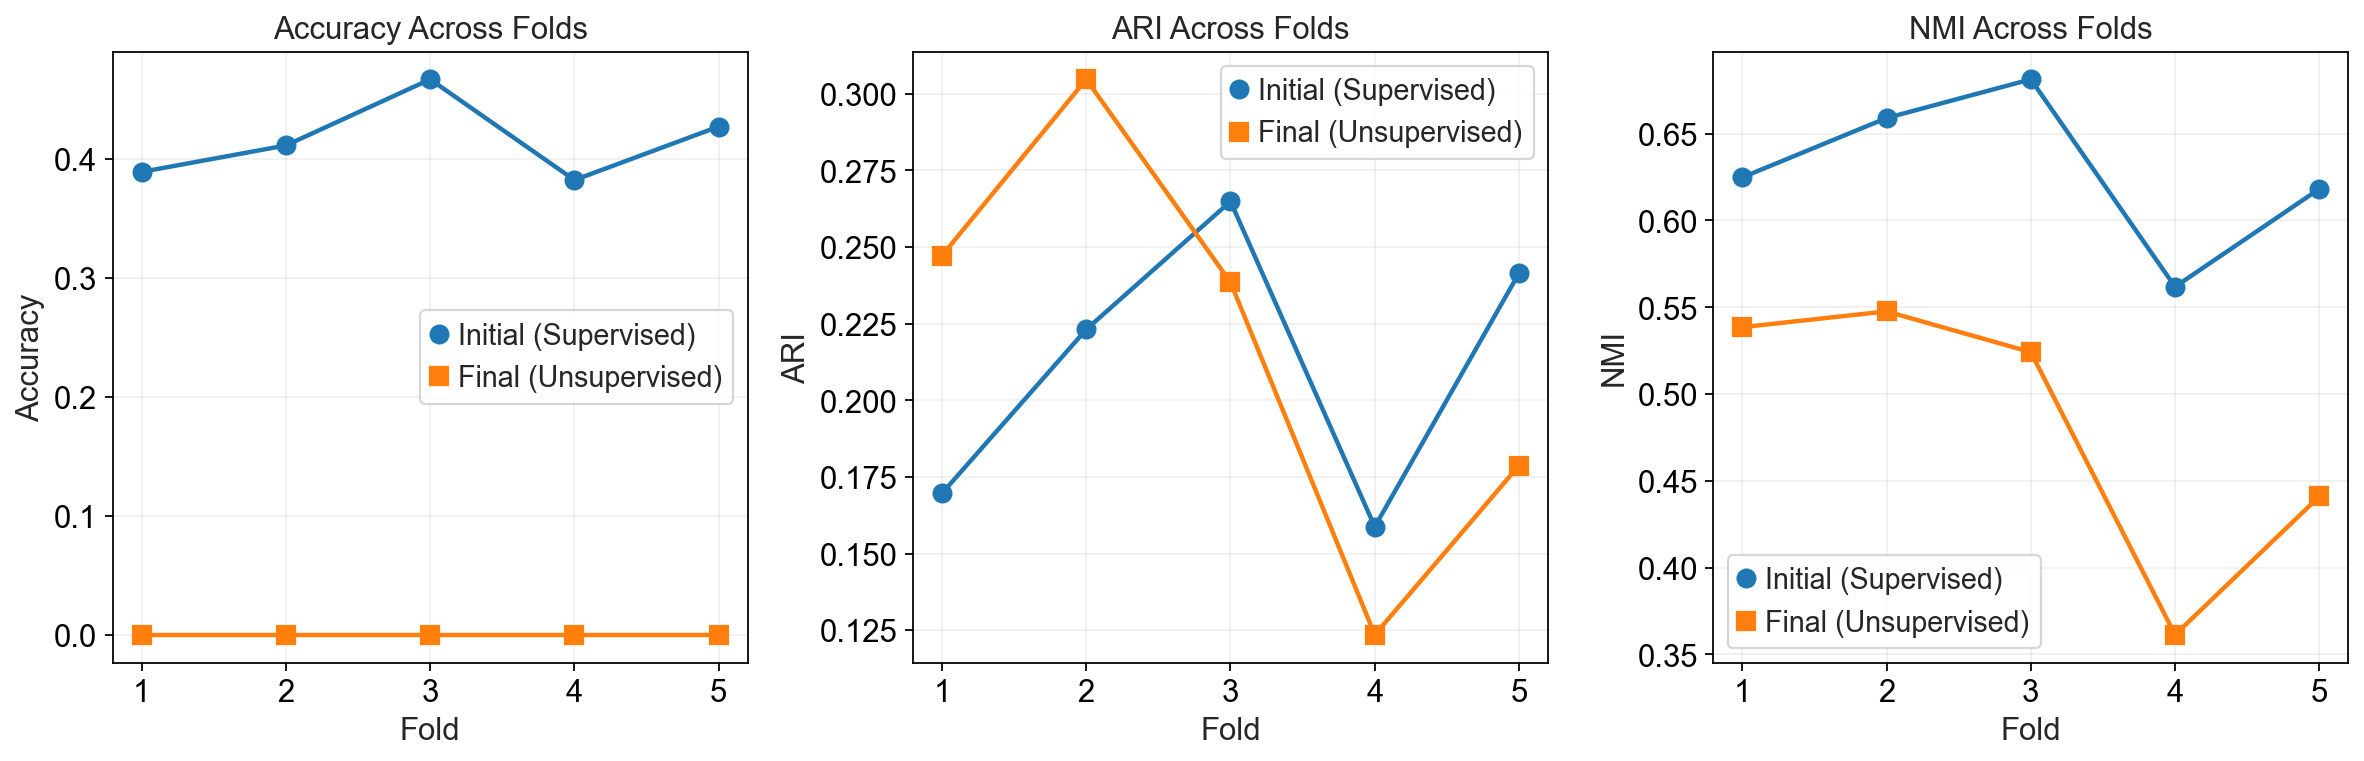

In [45]:
print(f"\n{'='*60}")
print("CROSS-VALIDATION SUMMARY")
print(f"{'='*60}")

if len(fold_analyses) > 0:
    # Collect metrics across folds
    initial_accs = [r['initial_metrics']['acc'] for r in fold_analyses]
    initial_aris = [r['initial_metrics']['ari'] for r in fold_analyses]
    initial_nmis = [r['initial_metrics']['nmi'] for r in fold_analyses]
    
    final_accs = [r['final_metrics']['acc'] for r in fold_analyses]
    final_aris = [r['final_metrics']['ari'] for r in fold_analyses]
    final_nmis = [r['final_metrics']['nmi'] for r in fold_analyses]
    
    print("Initial Supervised Training Results:")
    print(f"  Accuracy: {np.mean(initial_accs):.3f} ± {np.std(initial_accs):.3f}")
    print(f"  ARI: {np.mean(initial_aris):.3f} ± {np.std(initial_aris):.3f}")
    print(f"  NMI: {np.mean(initial_nmis):.3f} ± {np.std(initial_nmis):.3f}")
    
    print("\nFinal Unsupervised Clustering Results:")
    print(f"  Accuracy: {np.mean(final_accs):.3f} ± {np.std(final_accs):.3f}")
    print(f"  ARI: {np.mean(final_aris):.3f} ± {np.std(final_aris):.3f}")
    print(f"  NMI: {np.mean(final_nmis):.3f} ± {np.std(final_nmis):.3f}")
    
    # Create summary DataFrame
    summary_df = pd.DataFrame({
        'fold': range(len(all_results)),
        'initial_accuracy': initial_accs,
        'initial_ari': initial_aris,
        'initial_nmi': initial_nmis,
        'final_accuracy': final_accs,
        'final_ari': final_aris,
        'final_nmi': final_nmis
    })
    
    # Save summary
    summary_path = f'./results_summary_{TECHNIQUE}.csv'
    summary_df.to_csv(summary_path, index=False)
    print(f"\nDetailed results saved to: {summary_path}")
    
    # Display summary table
    print("\nDetailed Results by Fold:")
    print(summary_df.round(4))
    
    # Generate comparison plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    metrics = ['Accuracy', 'ARI', 'NMI']
    initial_data = [initial_accs, initial_aris, initial_nmis]
    final_data = [final_accs, final_aris, final_nmis]
    
    for i, (metric, initial, final) in enumerate(zip(metrics, initial_data, final_data)):
        folds = range(1, len(all_results) + 1)
        axes[i].plot(folds, initial, 'o-', label='Initial (Supervised)', linewidth=2, markersize=8)
        axes[i].plot(folds, final, 's-', label='Final (Unsupervised)', linewidth=2, markersize=8)
        axes[i].set_xlabel('Fold')
        axes[i].set_ylabel(metric)
        axes[i].set_title(f'{metric} Across Folds')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xticks(folds)
    
    plt.tight_layout()
    plt.savefig('./figures/cross_validation_summary.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("No successful results to summarize.")

In [38]:
# Choose the fold of interest
best_fold_idx = 2

Using fold 2 for detailed UMAP analysis (ARI: 0.2385)
Generating predictions and embeddings...
Fused data shape: (448, 68)
Number of true cell types: 27
Number of predicted clusters: 16
Performing Hungarian algorithm alignment...
Alignment completed!
Creating confusion matrix visualizations...


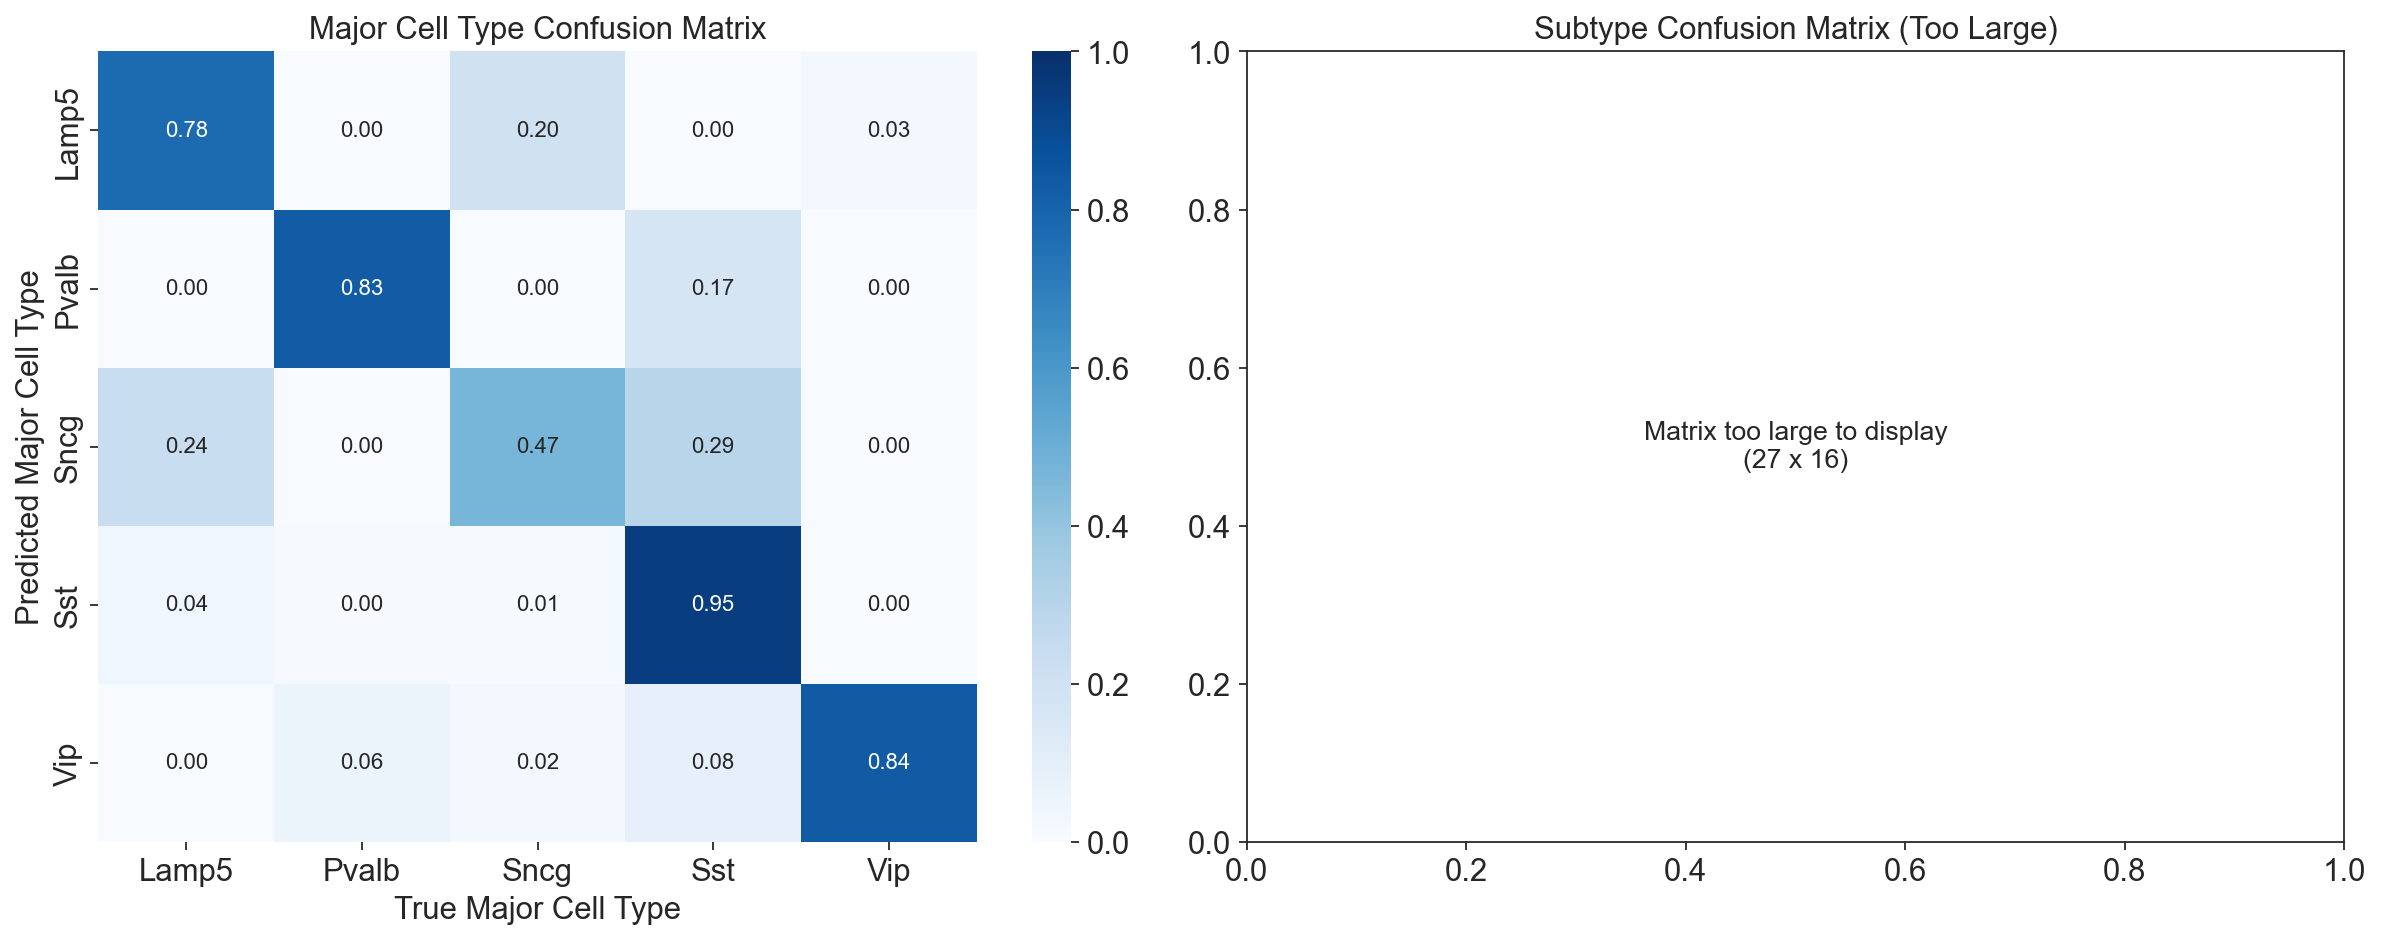

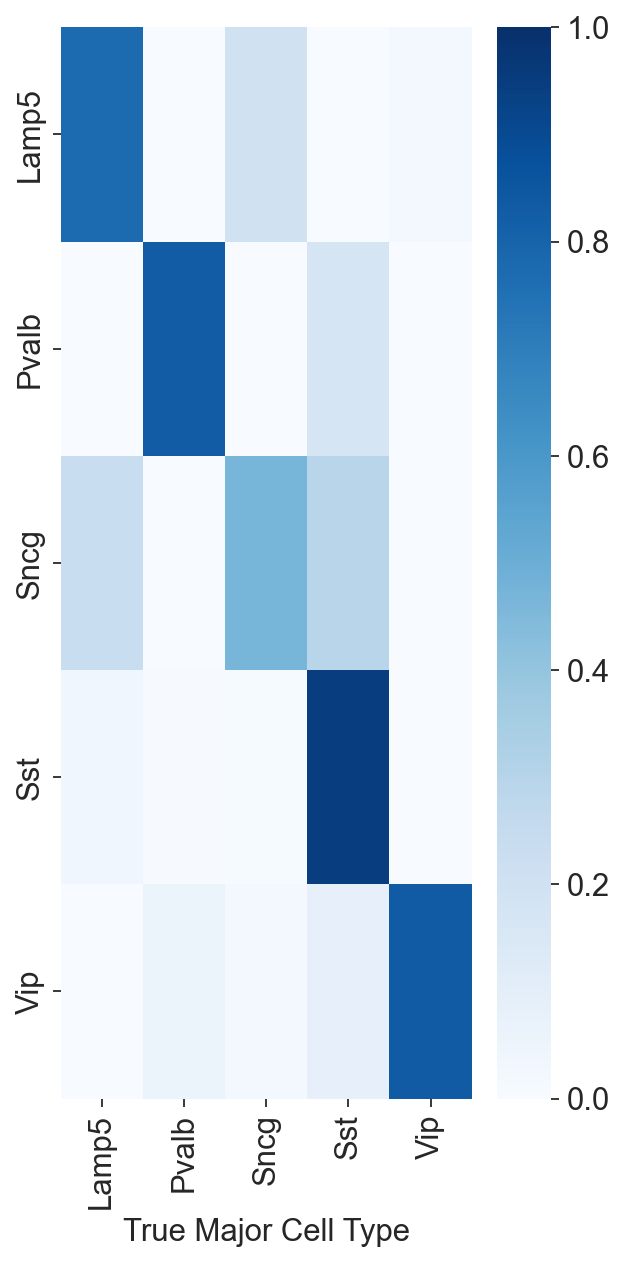

Creating UMAP visualizations...
UMAP coordinates shape: (448, 2)


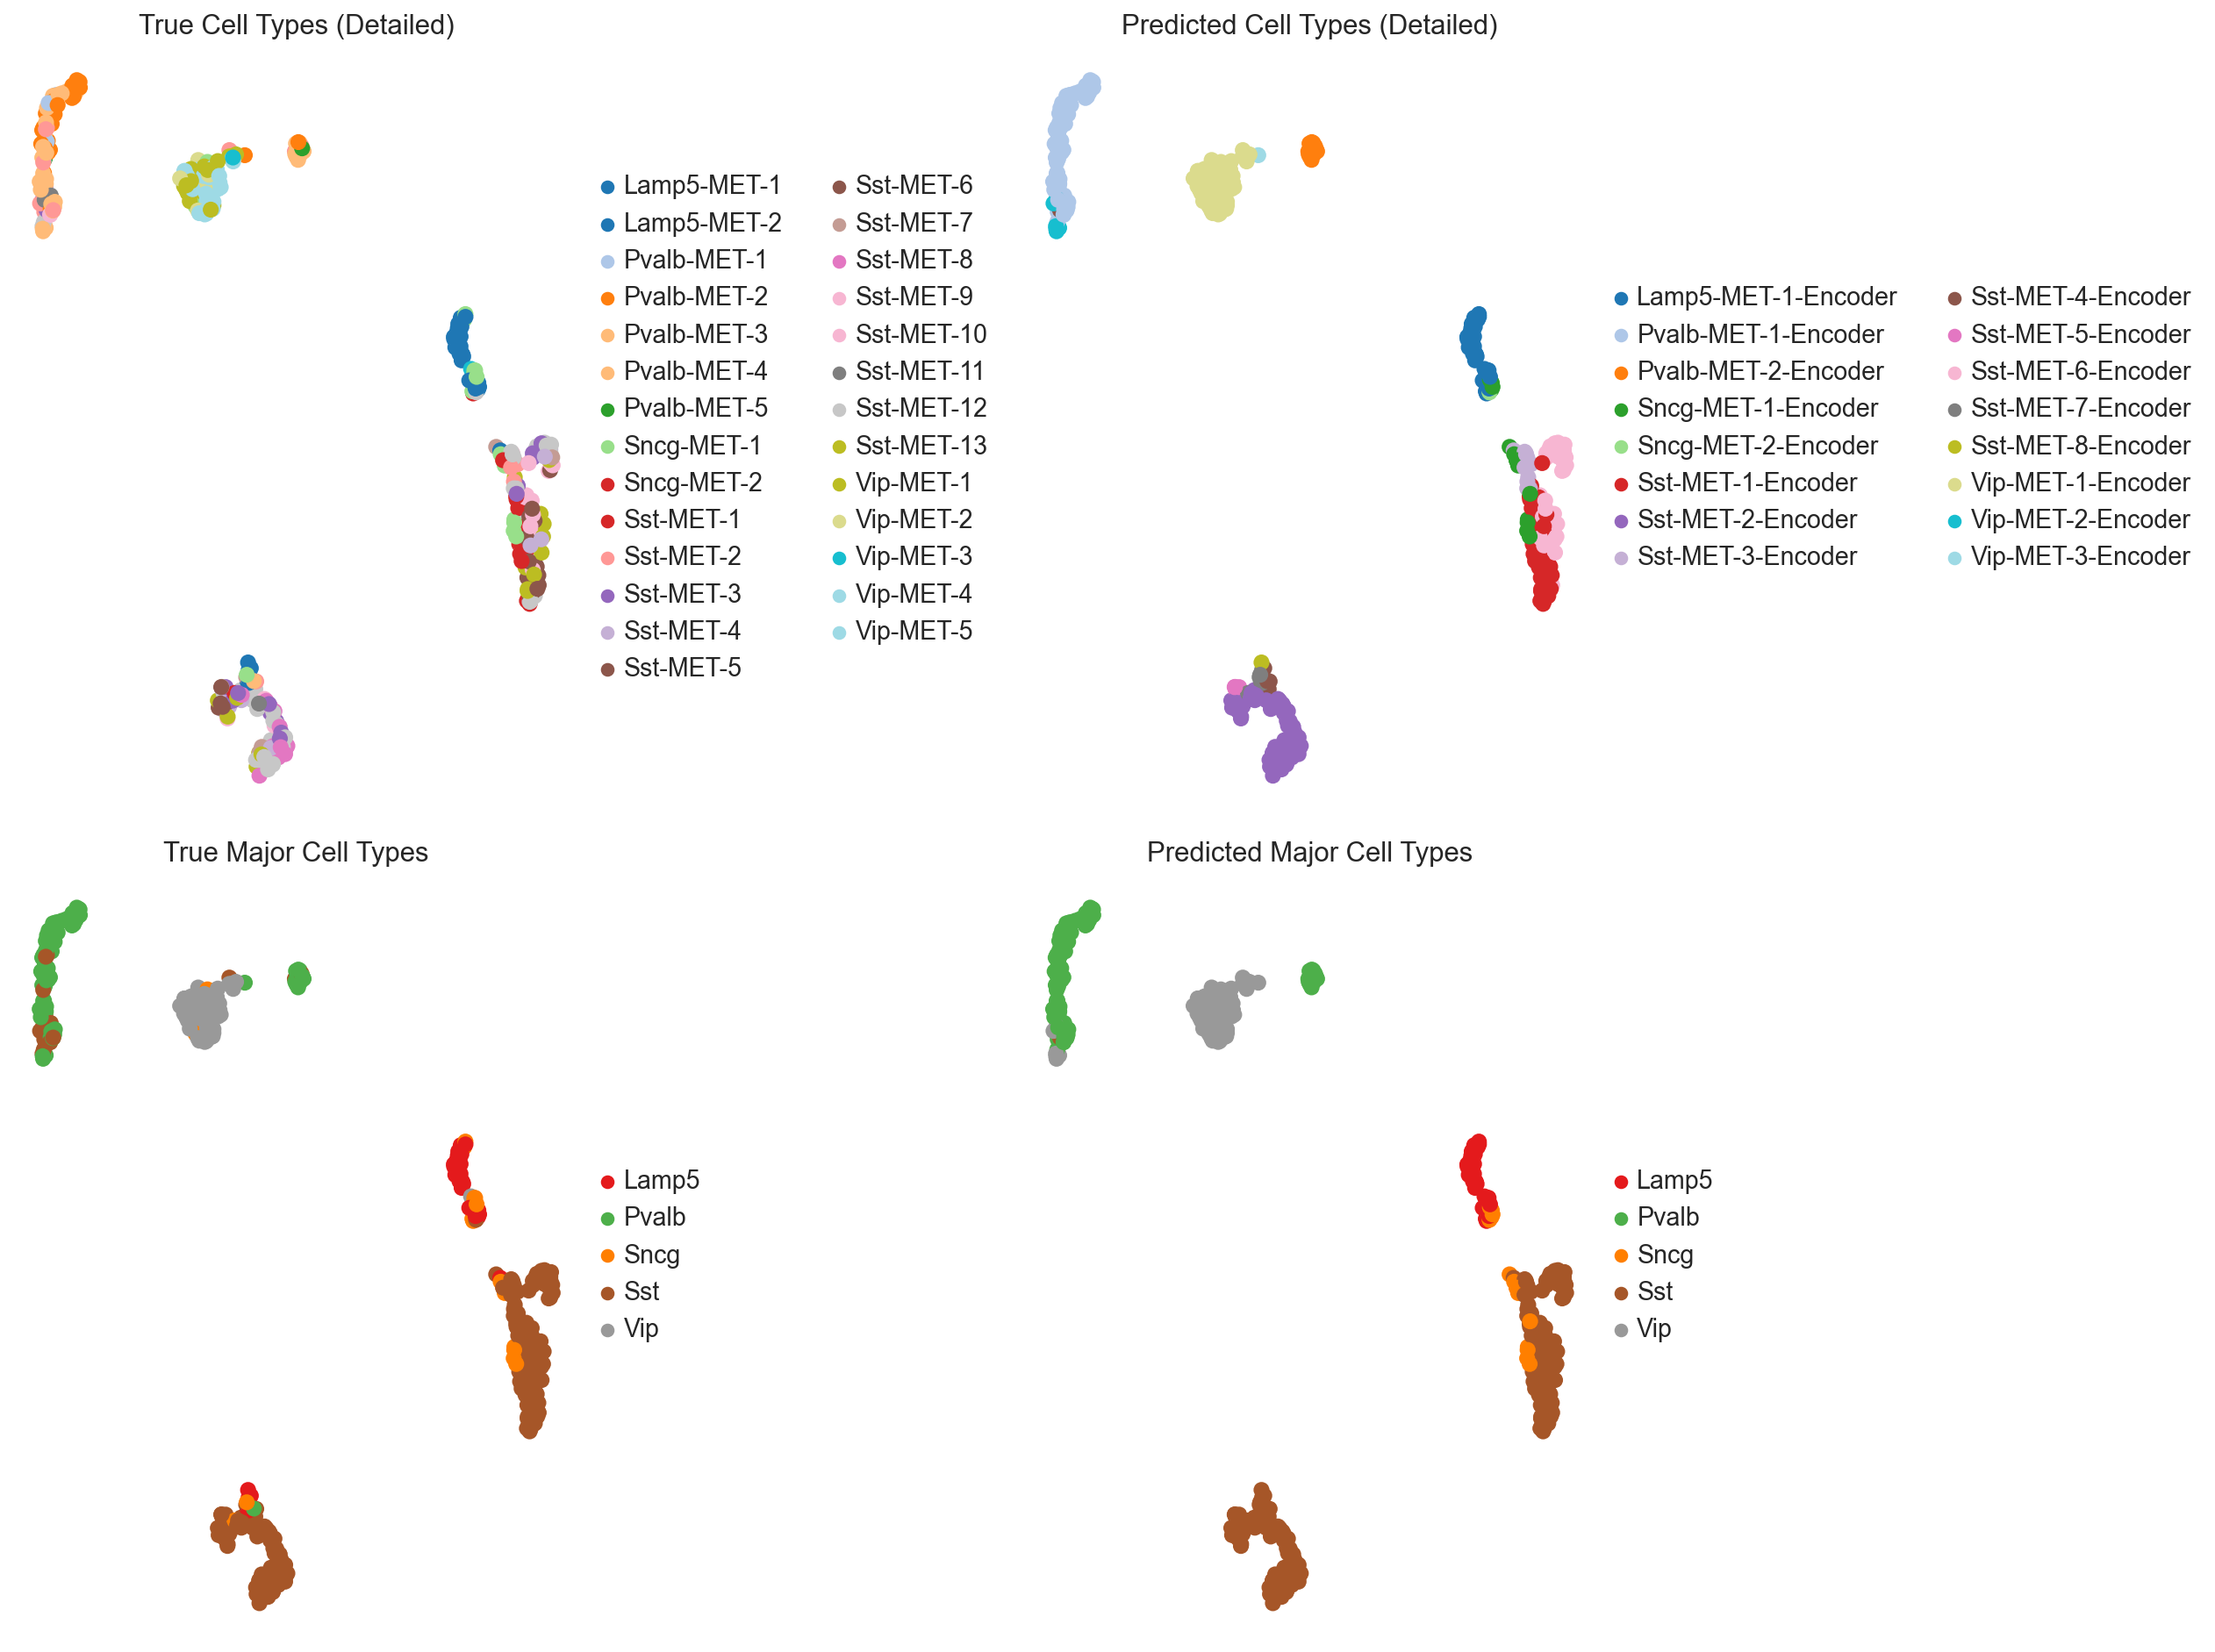

Creating individual UMAP plots...


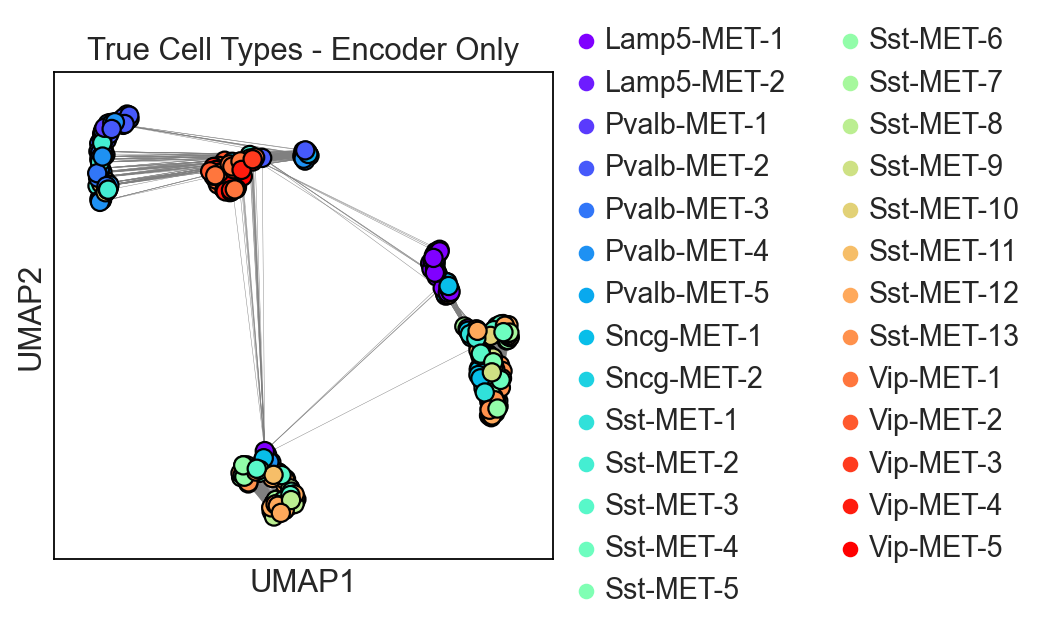

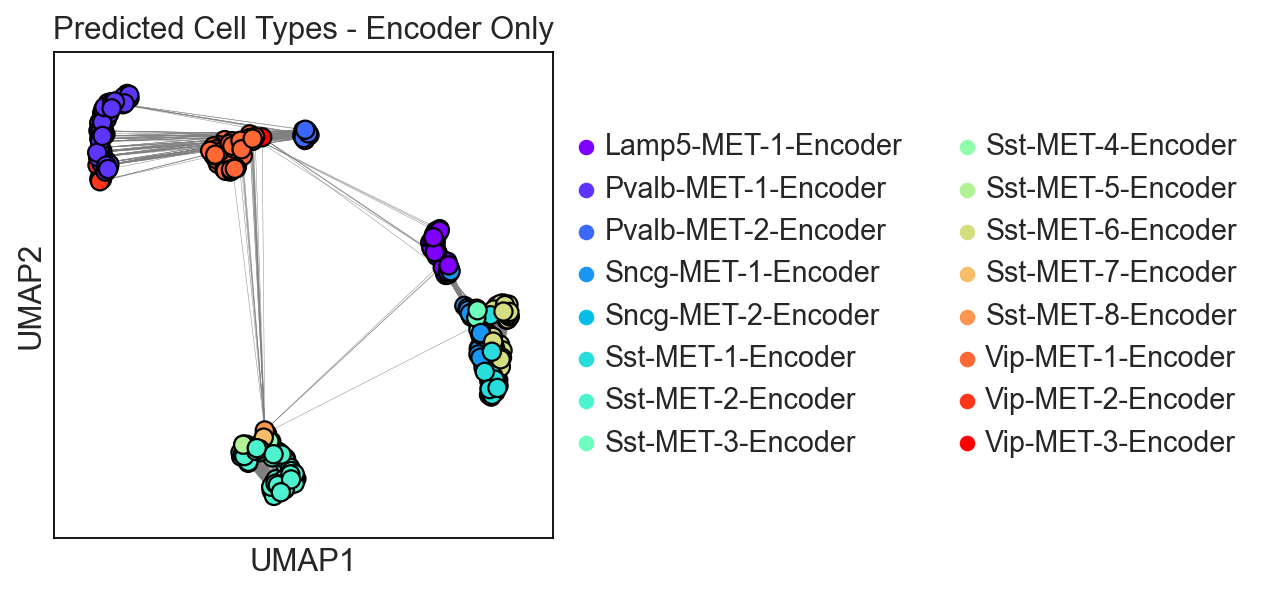

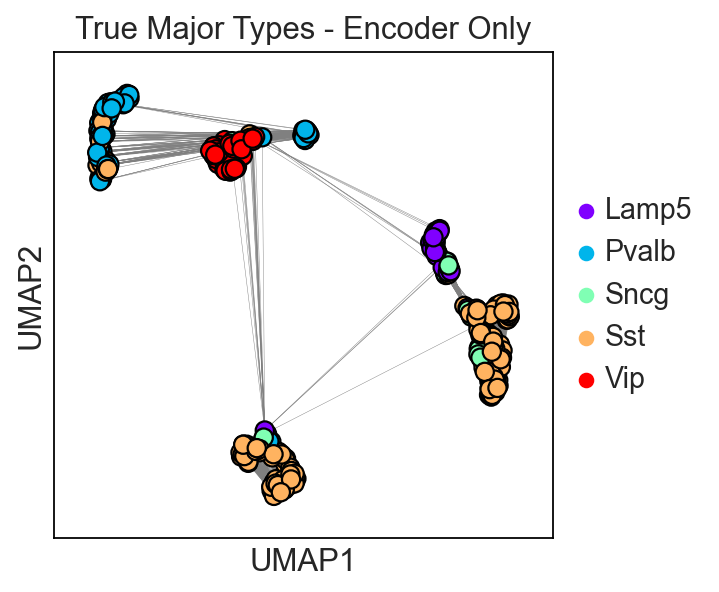

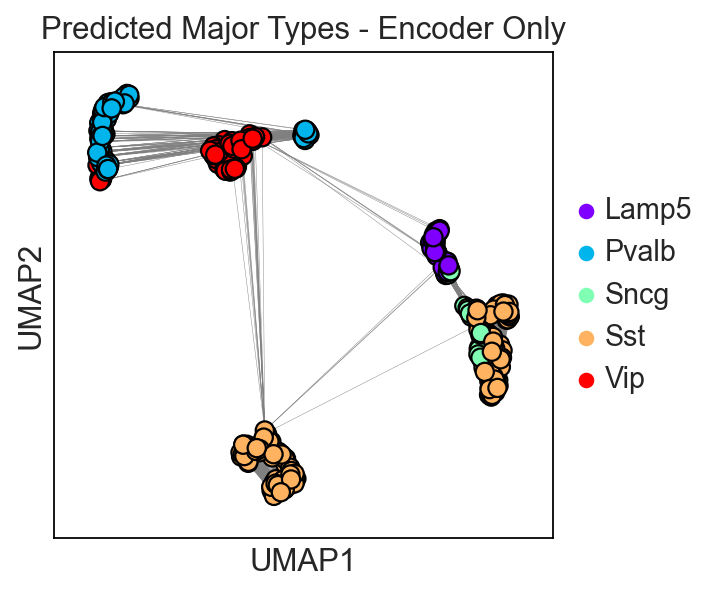

UMAP visualizations completed!

DETAILED METRICS FOR BEST FOLD
Detailed Subtype Clustering Metrics:
  Accuracy: 0.3415
  ARI: 0.2385
  NMI: 0.5241
  Homogeneity: 0.4509
  Completeness: 0.6093

Major Cell Type Clustering Metrics:
  Accuracy: 0.8683
  ARI: 0.7288
  NMI: 0.6741
  Homogeneity: 0.6797
  Completeness: 0.6685

Cluster Counts:
  True subtypes: 27
  Predicted subtypes: 16
  True major types: 5
  Predicted major types: 5
Saving detailed analysis results...
{'best_fold': 2, 'detailed_metrics': {'accuracy': np.float64(0.34151785714285715), 'ari': 0.23848749612513873, 'nmi': np.float64(0.5241241811910091), 'homogeneity': np.float64(0.4508547411992609), 'completeness': np.float64(0.6093008062384686)}, 'major_type_metrics': {'accuracy': np.float64(0.8683035714285714), 'ari': 0.7287977361884703, 'nmi': np.float64(0.6740521882960484), 'homogeneity': np.float64(0.679672005427528), 'completeness': np.float64(0.6684788382021092)}, 'cluster_counts': {'true_subtypes': 27, 'predicted_subtype

In [46]:
## Detailed UMAP Analysis

# Helper functions for analysis (from original notebook)
def ordered_cmat(labels, pred):
    """
    Compute the confusion matrix and accuracy corresponding to the best cluster-to-class assignment.
    """
    from sklearn.metrics import confusion_matrix
    from scipy.optimize import linear_sum_assignment
    
    cmat = confusion_matrix(labels, pred)
    ri, ci = linear_sum_assignment(-cmat)
    ordered = cmat[np.ix_(ri, ci)]
    acc = np.sum(np.diag(ordered))/np.sum(ordered)
    return acc, ordered

def assignment_align(labels1, labels2):
    """
    Align cluster assignments using Hungarian algorithm
    """
    from sklearn.metrics import confusion_matrix
    from scipy.optimize import linear_sum_assignment
    
    C_e_types = confusion_matrix(labels1, labels2)
    # Assign labels of clusters based on 'best match' with transcriptomic celltype label
    row_ind, col_ind = linear_sum_assignment(-C_e_types)
    order_2 = np.unique(labels2)[col_ind]
    labels2_matched = copy.deepcopy(labels2)
    for name, orig_name in zip(np.unique(labels2), order_2):
        ind = labels2 == orig_name
        labels2_matched[ind] = name
    return labels2_matched

# Select the best fold for detailed analysis (highest ARI score)
if fold_analyses:
    # best_fold_idx = np.argmax([r['final_metrics']['ari'] for r in fold_analyses])
    best_fold_result = fold_analyses[best_fold_idx]
    
    print(f"Using fold {best_fold_idx} for detailed UMAP analysis (ARI: {best_fold_result['final_metrics']['ari']:.4f})")
    
    # Get the best model and data
    best_model = all_results[best_fold_idx]['model']
    best_adatas_all = all_results[best_fold_idx]['adatas_all']
    
    # Generate predictions and fused representation
    print("Generating predictions and embeddings...")
    # predict_label = best_model.predict_label(best_adatas_all)
    adata_fused = best_model.infer(best_adatas_all)
    predict_label = adata_fused.obs['predicted_label'].values
    
    # Add true labels to the fused data
    adata_fused.obs['label'] = list(best_adatas_all[0].obs['label'])
    adata_fused.obs['label_less'] = [ct.split('-')[0] for ct in adata_fused.obs['label'].values]
    
    print(f"Fused data shape: {adata_fused.shape}")
    print(f"Number of true cell types: {len(adata_fused.obs['label'].unique())}")
    print(f"Number of predicted clusters: {len(adata_fused.obs['predicted_label'].unique())}")

# Perform Hungarian algorithm alignment for better visualization
print("Performing Hungarian algorithm alignment...")

# Convert predictions to numpy if needed
if hasattr(predict_label, 'cpu'):
    pseudo_label = predict_label.cpu().numpy()
else:
    pseudo_label = np.array(predict_label)

# Get unique labels for confusion matrix
from sklearn.utils.multiclass import unique_labels

# Create confusion matrix and perform optimal assignment
cmat = confusion_matrix(adata_fused.obs['label'], pseudo_label)
ri, ci = linear_sum_assignment(-cmat)
ordered_all = cmat[np.ix_(ri, ci)]

# Create mapping dictionary for renaming predicted clusters
major_sub_names = {}
pred_labels_re_order = copy.deepcopy(pseudo_label)

unique_true_labels = unique_labels(adata_fused.obs['label'], pseudo_label)[ri]
unique_pred_labels = unique_labels(adata_fused.obs['label'], pseudo_label)[ci]

for re_order, (lb_correct, lb) in enumerate(zip(unique_true_labels, unique_pred_labels)):
    idx = pseudo_label == lb
    if any(idx):
        nm = '-'.join(lb_correct.split('-')[:-1])
        if nm in major_sub_names.keys():
            major_sub_names[nm] += 1
        else:
            major_sub_names[nm] = 1
        
        pred_labels_re_order[idx] = f'{nm}-{major_sub_names[nm]}-Encoder'

# Update the predicted labels in adata_fused
adata_fused.obs['predicted_label'] = pred_labels_re_order
adata_fused.obs['predicted_label_less'] = [ct.split('-')[0] for ct in adata_fused.obs['predicted_label'].values]

print("Alignment completed!")

# Create confusion matrix heatmaps
print("Creating confusion matrix visualizations...")

# Set style for better plots
sns.set_style('ticks')
plt.rcParams['font.size'] = 10

# Major cell type confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Major type heatmap
cmat_major = confusion_matrix(adata_fused.obs['predicted_label_less'], adata_fused.obs['label_less'])
cmat_major = cmat_major[:, cmat_major.sum(axis=0) != 0]
cmat_major = cmat_major[cmat_major.sum(axis=1) != 0, :]
cmat_major_norm = (cmat_major.T / cmat_major.sum(axis=1)).T

sns.heatmap(cmat_major_norm, ax=ax1, 
           yticklabels=np.unique(adata_fused.obs['predicted_label_less']),
           xticklabels=np.unique(adata_fused.obs['label_less']),
           vmin=0, vmax=1, cmap='Blues', annot=True, fmt='.2f')
ax1.set_xlabel('True Major Cell Type')
ax1.set_ylabel('Predicted Major Cell Type')
ax1.set_title('Major Cell Type Confusion Matrix')

# Subtype confusion matrix
ordered_filtered = ordered_all[:, ordered_all.sum(axis=0) != 0]
ordered_filtered = ordered_filtered[ordered_filtered.sum(axis=1) != 0, :]
ordered_norm = (ordered_filtered.T / ordered_filtered.sum(axis=1)).T

# Only show if not too large
if ordered_norm.shape[0] <= 20 and ordered_norm.shape[1] <= 20:
    sns.heatmap(ordered_norm, ax=ax2,
               xticklabels=unique_labels(adata_fused.obs['label']),
               yticklabels=unique_labels(adata_fused.obs['predicted_label']),
               vmin=0, vmax=1, cmap='Blues')
    ax2.set_xlabel('True Subtype')
    ax2.set_ylabel('Predicted Subtype')
    ax2.set_title('Subtype Confusion Matrix')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    plt.setp(ax2.get_yticklabels(), rotation=0)
else:
    ax2.text(0.5, 0.5, f'Matrix too large to display\n({ordered_norm.shape[0]} x {ordered_norm.shape[1]})', 
             ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    ax2.set_title('Subtype Confusion Matrix (Too Large)')

plt.tight_layout()
plt.savefig('./figures/encoder_only_confusion_matrices.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Save individual heatmaps as in original
fig1, ax1 = plt.subplots(figsize=(4, 8))
sns.heatmap(cmat_major_norm, ax=ax1,
           yticklabels=np.unique(adata_fused.obs['predicted_label_less']),
           xticklabels=np.unique(adata_fused.obs['label_less']),
           vmin=0, vmax=1, cmap='Blues')
ax1.set_xlabel('True Major Cell Type')
plt.tight_layout()
plt.savefig('./figures/encoder_only_major_matching_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Create UMAP visualizations
print("Creating UMAP visualizations...")

# Ensure UMAP is computed with consistent parameters
sc.settings.figdir = './figures/'  # Set scanpy figure directory
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Recompute UMAP with specific parameters for consistency
sc.tl.pca(adata_fused, n_comps=50)
sc.pp.neighbors(adata_fused, n_neighbors=30, n_pcs=50)
sc.tl.umap(adata_fused, min_dist=0.3, spread=1.0)

print(f"UMAP coordinates shape: {adata_fused.obsm['X_umap'].shape}")

# Create the main UMAP plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: True labels (detailed subtypes)
sc.pl.umap(adata_fused, 
           color='label', 
           palette='tab20', 
           show=False, 
           ax=axes[0,0],
           legend_loc='right margin',
           frameon=False,
           title='True Cell Types (Detailed)')

# Plot 2: Predicted labels (detailed subtypes)  
sc.pl.umap(adata_fused,
           color='predicted_label',
           palette='tab20',
           show=False,
           ax=axes[0,1],
           legend_loc='right margin',
           frameon=False,
           title='Predicted Cell Types (Detailed)')

# Plot 3: True major types
sc.pl.umap(adata_fused,
           color='label_less',
           palette='Set1',
           show=False,
           ax=axes[1,0],
           legend_loc='right margin',
           frameon=False,
           title='True Major Cell Types')

# Plot 4: Predicted major types
sc.pl.umap(adata_fused,
           color='predicted_label_less',
           palette='Set1',
           show=False,
           ax=axes[1,1],
           legend_loc='right margin',
           frameon=False,
           title='Predicted Major Cell Types')

plt.tight_layout()
plt.savefig('./figures/encoder_only_umap_comparison.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Individual UMAP plots (matching original notebook style)
print("Creating individual UMAP plots...")

# True detailed subtypes
sc.pl.umap(adata_fused, 
           color=['label'], 
           palette='rainbow', 
           show=True, 
           edges=True, 
           edges_width=0.2, 
           edgecolor='k', 
           title='True Cell Types - Encoder Only', 
           save='_encoder_only_true_detailed.pdf')

# Predicted detailed subtypes
sc.pl.umap(adata_fused,
           color=['predicted_label'],
           palette='rainbow',
           show=True,
           edges=True,
           edges_width=0.2,
           edgecolor='k',
           title='Predicted Cell Types - Encoder Only',
           save='_encoder_only_predicted_detailed.pdf')

# True major types
sc.pl.umap(adata_fused,
           color=['label_less'],
           palette='rainbow',
           show=True,
           edges=True,
           edges_width=0.2,
           edgecolor='k',
           title='True Major Types - Encoder Only',
           save='_encoder_only_true_major.pdf')

# Predicted major types
sc.pl.umap(adata_fused,
           color=['predicted_label_less'],
           palette='rainbow',
           show=True,
           edges=True,
           edges_width=0.2,
           edgecolor='k',
           title='Predicted Major Types - Encoder Only',
           save='_encoder_only_predicted_major.pdf')

print("UMAP visualizations completed!")

# Calculate and display final metrics for the best fold
print(f"\n{'='*60}")
print("DETAILED METRICS FOR BEST FOLD")
print(f"{'='*60}")

# Compute detailed metrics
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score

true_labels = adata_fused.obs['label'].values
pred_labels = adata_fused.obs['predicted_label'].values
true_major = adata_fused.obs['label_less'].values  
pred_major = adata_fused.obs['predicted_label_less'].values

# Encode labels for metric computation
le_true = preprocessing.LabelEncoder()
le_pred = preprocessing.LabelEncoder()
le_true_major = preprocessing.LabelEncoder()
le_pred_major = preprocessing.LabelEncoder()

true_encoded = le_true.fit_transform(true_labels)
pred_encoded = le_pred.fit_transform(pred_labels)
true_major_encoded = le_true_major.fit_transform(true_major)
pred_major_encoded = le_pred_major.fit_transform(pred_major)

# Detailed subtype metrics
acc_detailed, _ = ordered_cmat(true_encoded, pred_encoded)
ari_detailed = adjusted_rand_score(true_encoded, pred_encoded)
nmi_detailed = normalized_mutual_info_score(true_encoded, pred_encoded, average_method='geometric')
homogeneity_detailed = homogeneity_score(true_encoded, pred_encoded)
completeness_detailed = completeness_score(true_encoded, pred_encoded)

# Major type metrics
acc_major, _ = ordered_cmat(true_major_encoded, pred_major_encoded)
ari_major = adjusted_rand_score(true_major_encoded, pred_major_encoded)
nmi_major = normalized_mutual_info_score(true_major_encoded, pred_major_encoded, average_method='geometric')
homogeneity_major = homogeneity_score(true_major_encoded, pred_major_encoded)
completeness_major = completeness_score(true_major_encoded, pred_major_encoded)

print("Detailed Subtype Clustering Metrics:")
print(f"  Accuracy: {acc_detailed:.4f}")
print(f"  ARI: {ari_detailed:.4f}")
print(f"  NMI: {nmi_detailed:.4f}")
print(f"  Homogeneity: {homogeneity_detailed:.4f}")
print(f"  Completeness: {completeness_detailed:.4f}")

print("\nMajor Cell Type Clustering Metrics:")
print(f"  Accuracy: {acc_major:.4f}")
print(f"  ARI: {ari_major:.4f}")
print(f"  NMI: {nmi_major:.4f}")
print(f"  Homogeneity: {homogeneity_major:.4f}")
print(f"  Completeness: {completeness_major:.4f}")

print(f"\nCluster Counts:")
print(f"  True subtypes: {len(np.unique(true_labels))}")
print(f"  Predicted subtypes: {len(np.unique(pred_labels))}")
print(f"  True major types: {len(np.unique(true_major))}")
print(f"  Predicted major types: {len(np.unique(pred_major))}")

# Save detailed results
print("Saving detailed analysis results...")

# Create comprehensive results dictionary
detailed_results = {
    'best_fold': best_fold_idx,
    'detailed_metrics': {
        'accuracy': acc_detailed,
        'ari': ari_detailed, 
        'nmi': nmi_detailed,
        'homogeneity': homogeneity_detailed,
        'completeness': completeness_detailed
    },
    'major_type_metrics': {
        'accuracy': acc_major,
        'ari': ari_major,
        'nmi': nmi_major, 
        'homogeneity': homogeneity_major,
        'completeness': completeness_major
    },
    'cluster_counts': {
        'true_subtypes': len(np.unique(true_labels)),
        'predicted_subtypes': len(np.unique(pred_labels)),
        'true_major_types': len(np.unique(true_major)),
        'predicted_major_types': len(np.unique(pred_major))
    }
}

# # Save as JSON
# import json
# with open(f'./encoder_only_detailed_results.json', 'w') as f:
#     json.dump(detailed_results, f, indent=2)

print(detailed_results)

# Save the fused AnnData object
adata_fused.write_h5ad('./encoder_only_best_fold_results.h5ad')

print("Analysis completed and saved!")
print(f"- Detailed results: ./encoder_only_detailed_results.json")
print(f"- Fused data: ./encoder_only_best_fold_results.h5ad")
print(f"- Figures saved in: ./figures/")

# Comparison with cross-validation averages
print(f"\n{'='*60}")
print("COMPARISON: BEST FOLD vs CROSS-VALIDATION AVERAGE")
print(f"{'='*60}")

if len(fold_analyses) > 1:
    cv_ari_mean = np.mean([r['final_metrics']['ari'] for r in fold_analyses])
    cv_ari_std = np.std([r['final_metrics']['ari'] for r in fold_analyses])
    cv_nmi_mean = np.mean([r['final_metrics']['nmi'] for r in fold_analyses])
    cv_nmi_std = np.std([r['final_metrics']['nmi'] for r in fold_analyses])
    
    print("ARI Comparison:")
    print(f"  Best fold: {ari_detailed:.4f}")
    print(f"  CV average: {cv_ari_mean:.4f} ± {cv_ari_std:.4f}")
    print(f"  Difference: {ari_detailed - cv_ari_mean:+.4f}")
    
    print("\nNMI Comparison:")
    print(f"  Best fold: {nmi_detailed:.4f}")
    print(f"  CV average: {cv_nmi_mean:.4f} ± {cv_nmi_std:.4f}")
    print(f"  Difference: {nmi_detailed - cv_nmi_mean:+.4f}")
else:
    print("Only one fold available - no comparison possible")

print(f"\n{'='*60}")
print("ENCODER-ONLY PATCHSEQ ANALYSIS COMPLETE")
print(f"{'='*60}")

Average maximum probability: 0.5598
Very high values (>0.95) suggest overconfident assignments


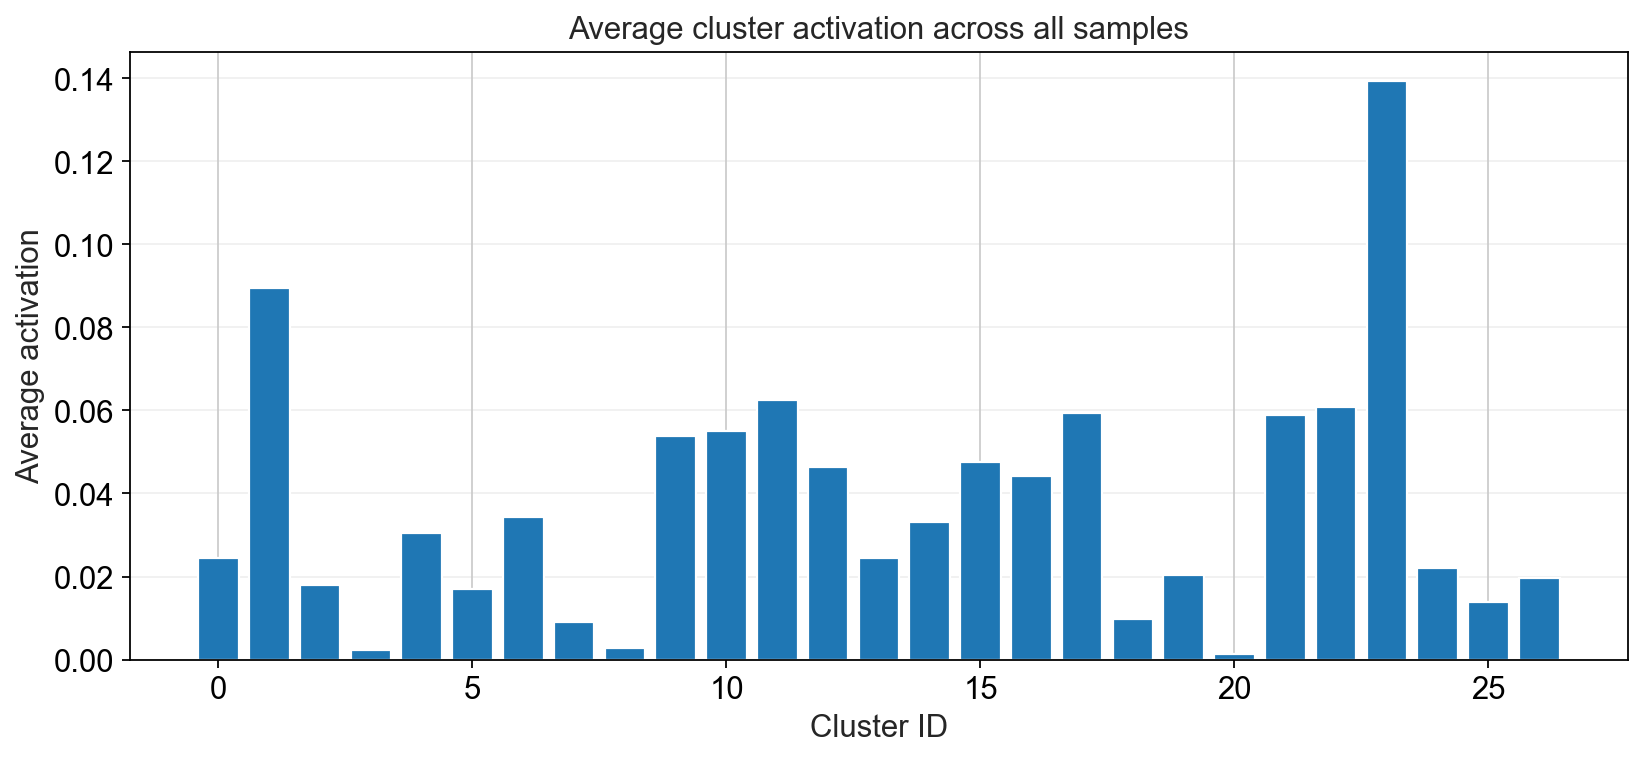

Clusters with near-zero activation: 5 out of 27
Specifically: [ 3  7  8 18 20]


In [40]:
# Run model in evaluation mode and get raw cluster outputs
model.model.eval()
with torch.no_grad():
    # Get a dataloader for your dataset
    from src.data import create_dataloader
    dataloader = create_dataloader(model.model, adatas_all, shuffle=False)
    
    # Extract cluster outputs directly
    all_cluster_outputs = []
    for modalities, labels in dataloader:
        # Forward pass
        model.model(modalities, labels)
        # Get cluster outputs from the best head
        cluster_outputs = model.model.cluster_outputs[model.model.best_head]
        # Apply softmax to get probabilities
        probs = model.model.prob_layer(cluster_outputs)
        all_cluster_outputs.append(probs.cpu())
    
    # Concatenate all batches
    all_probs = torch.cat(all_cluster_outputs, dim=0).numpy()

# Calculate cluster confidence metrics
avg_max_prob = np.mean(np.max(all_probs, axis=1))
cluster_activations = np.mean(all_probs, axis=0)

print(f"Average maximum probability: {avg_max_prob:.4f}")
print(f"Very high values (>0.95) suggest overconfident assignments")

# Plot average activation per cluster
plt.figure(figsize=(12, 5))
plt.bar(range(27), cluster_activations)
plt.xlabel('Cluster ID')
plt.ylabel('Average activation')
plt.title('Average cluster activation across all samples')
plt.grid(axis='y', alpha=0.3)
plt.savefig('./figures/cluster_activations.pdf')
plt.show()

# Identify near-zero activations (collapsed clusters)
near_zero = np.where(cluster_activations < 0.01)[0]
print(f"Clusters with near-zero activation: {len(near_zero)} out of 27")
print(f"Specifically: {near_zero}")

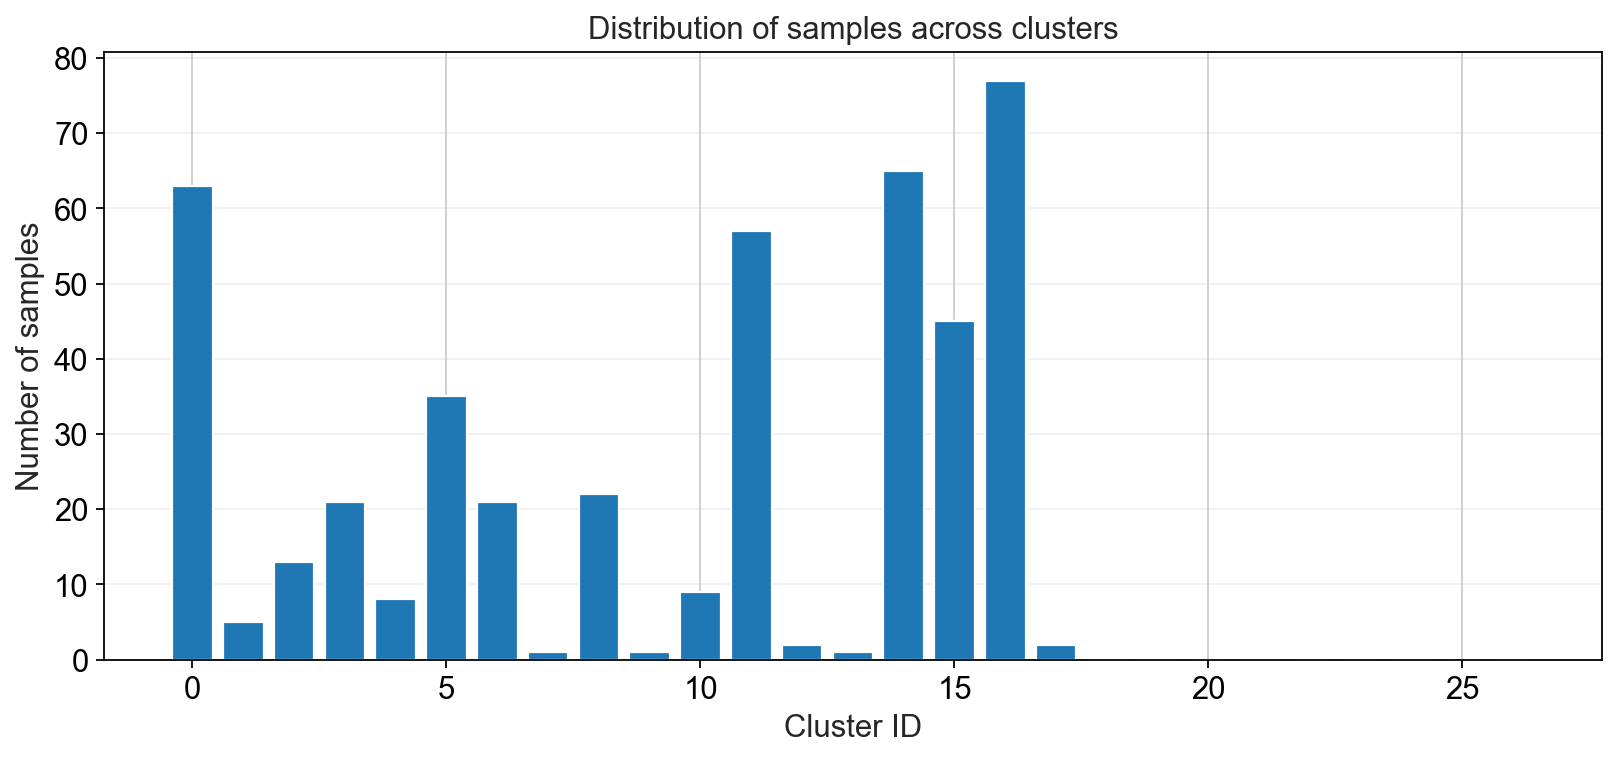

Active clusters: 18 out of 27
Largest cluster: 77 samples (cluster 16)
Average cluster size: 24.9 samples
Empty clusters: 9


In [41]:
import matplotlib.pyplot as plt

# Count samples per cluster
cluster_counts = np.bincount(predictions, minlength=27)

# Plot cluster distribution
plt.figure(figsize=(12, 5))
plt.bar(range(27), cluster_counts)
plt.xlabel('Cluster ID')
plt.ylabel('Number of samples')
plt.title('Distribution of samples across clusters')
plt.grid(axis='y', alpha=0.3)
plt.savefig('./figures/cluster_distribution.pdf')
plt.show()

# Calculate cluster statistics
active_clusters = np.where(cluster_counts > 0)[0]
print(f"Active clusters: {len(active_clusters)} out of 27")
print(f"Largest cluster: {np.max(cluster_counts)} samples (cluster {np.argmax(cluster_counts)})")
print(f"Average cluster size: {np.mean(cluster_counts[active_clusters]):.1f} samples")
print(f"Empty clusters: {27 - len(active_clusters)}")

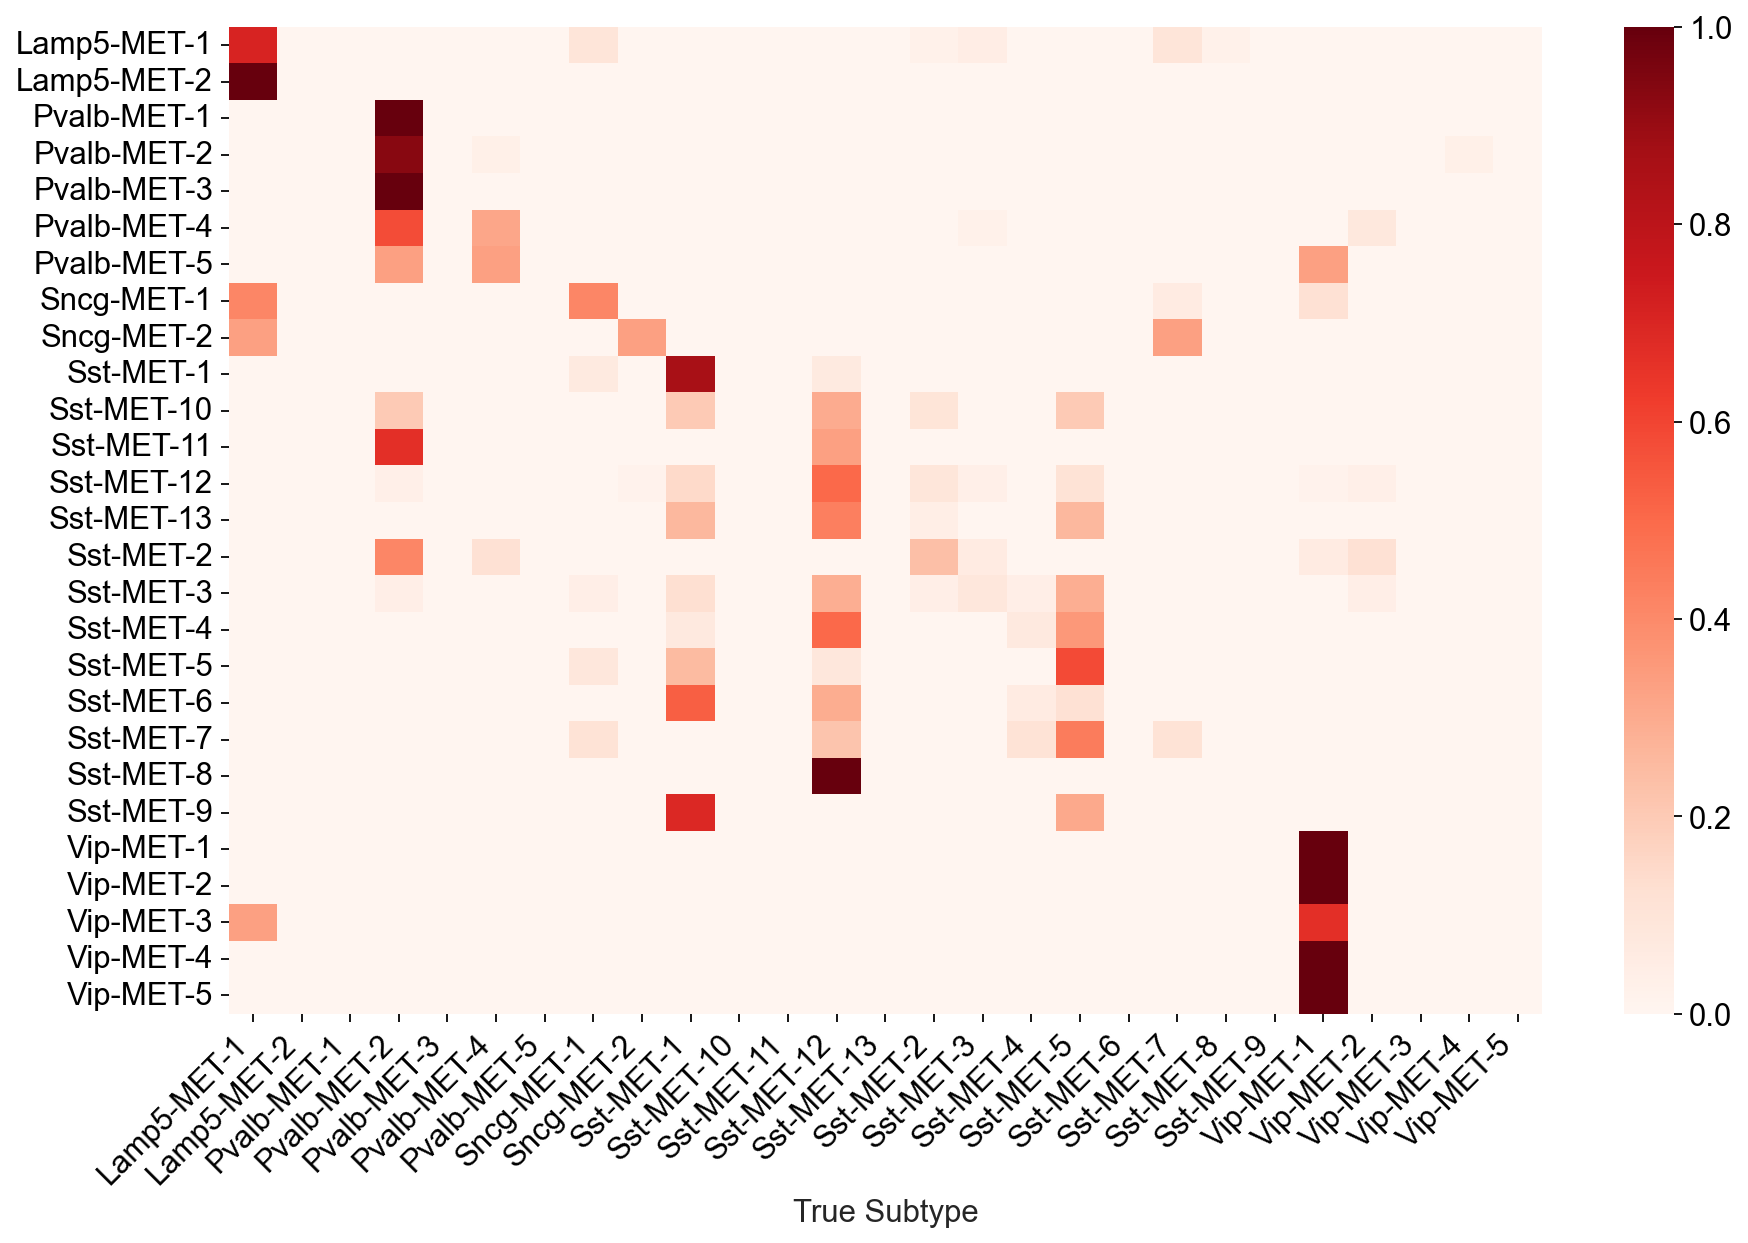

In [42]:
# Subtype confusion matrix
# ordered_filtered = ordered_all[:, ordered_all.sum(axis=0) != 0]
# ordered_filtered = ordered_filtered[ordered_filtered.sum(axis=1) != 0, :]
ordered_norm = (ordered_all.T / ordered_all.sum(axis=1)).T


fig2, ax2 = plt.subplots(figsize=(12, 8))
sns.heatmap(ordered_norm, ax=ax2,
            xticklabels=unique_labels(adata_fused.obs['label']),
            yticklabels=unique_labels(adata_fused.obs['label']),
            vmin=0, vmax=1, cmap='Reds')
ax2.set_xlabel('True Subtype')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.savefig('./figures/encoder_only_sub_matching_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.show()



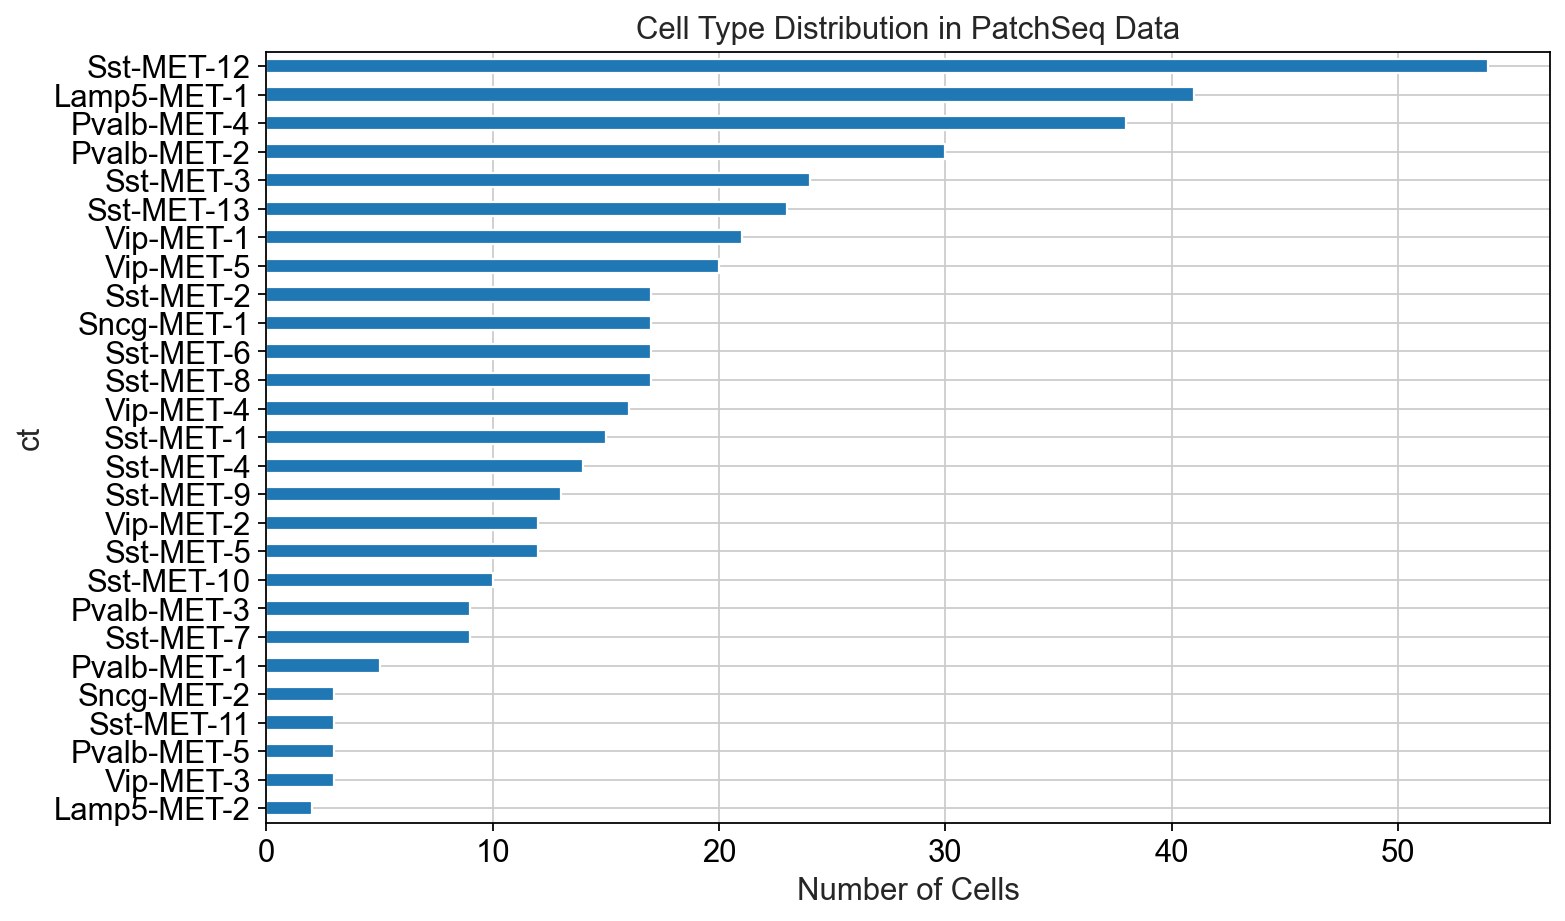

In [43]:
# Visualize cell type distribution
plt.figure(figsize=(10, 6))
ct_df.ct.value_counts().sort_values().plot(kind='barh')
plt.title('Cell Type Distribution in PatchSeq Data')
plt.xlabel('Number of Cells')
plt.tight_layout()
plt.savefig('./figures/cell_type_distribution.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
model.model

EncoderOnlyModel(
  (encoders): ModuleList(
    (0): MLP(
      (layers): ModuleList(
        (0): Linear(in_features=1252, out_features=1024, bias=True)
        (1): Dropout(p=0.3, inplace=False)
        (2): ReLU()
        (3): Linear(in_features=1024, out_features=512, bias=True)
        (4): Dropout(p=0.1, inplace=False)
        (5): ReLU()
        (6): Linear(in_features=512, out_features=256, bias=True)
        (7): ReLU()
        (8): Linear(in_features=256, out_features=128, bias=True)
        (9): ReLU()
        (10): Linear(in_features=128, out_features=68, bias=True)
        (11): LayerNorm((68,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): MLP(
      (layers): ModuleList(
        (0): Linear(in_features=68, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128